<a href="https://colab.research.google.com/github/Bharathkumar1404/data-science-final-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INTIALIZING THE LIBRARIES

In [129]:
#Initializing the matplotlib library
!pip install matplotlib

In [130]:
#Intializing the pmdarima library
!pip install pmdarima

In [131]:
#Initializing the prophet model library
!pip install prophet

In [132]:
#Initializing the statsmodels library
!pip install statsmodels

In [133]:
# Install PyTorch Forecasting for time series modeling.
!pip install pytorch-forecasting

In [134]:
# Install PyTorch Lightning for scalable deep learning models.
!pip install pytorch-lightning

In [135]:
# Install specific versions of PyTorch Forecasting, PyTorch Lightning, and Torch for compatibility.
! pip install pytorch-forecasting==1.0.0
! pip installpytorch-lightning==2.0.1.post0
!pip Install torch==2.0.0

ERROR: unknown command "installpytorch-lightning==2.0.1.post0"
ERROR: unknown command "Install" - maybe you meant "install"


IMPORTING THE REQURIED LIBRARIES

In [136]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Flatten
import torch
from torch.nn import functional as F
from pytorch_lightning import LightningModule
import warnings
warnings.filterwarnings("ignore")


In [137]:
# Importing the dataset using pandas' read_csv() function.
weather_data = pd.read_csv('pune.csv')
weather_data.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2008-12-11 00:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,10,31,72,0.0,1013,18,10,114,5,pune
1,2008-12-11 01:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,9,30,72,0.0,1013,19,10,125,4,pune
2,2008-12-11 02:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,136,4,pune
3,2008-12-11 03:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,147,4,pune
4,2008-12-11 04:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,7,23,68,0.0,1014,20,10,136,4,pune


In [138]:
# Dropping irrelevant columns from the weather_data DataFrame
wf = weather_data.drop(columns=['DewPointC','cloudcover','moonrise', 'moonset', 'sunrise', 'sunset','sunHour','totalSnow_cm','uvIndex','moon_illumination','visibility','winddirDegree','windspeedKmph'])
wf.head()

,date_time,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,humidity,precipMM,pressure,tempC,location
0,2008-12-11 00:00:00,30,18,18,18,18,10,72,0.0,1013,18,pune
1,2008-12-11 01:00:00,30,18,19,19,19,9,72,0.0,1013,19,pune
2,2008-12-11 02:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
3,2008-12-11 03:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
4,2008-12-11 04:00:00,30,18,20,20,20,7,68,0.0,1014,20,pune


In [139]:
# Converting 'date_time' to datetime format and extracting year, month, day, and hour; filtering data for years between 2009 and 2021.
wf['date_time'] = pd.to_datetime(wf['date_time'])
wf['year'] = wf['date_time'].dt.year
wf['month'] = wf['date_time'].dt.month
wf['day'] = wf['date_time'].dt.day
wf['hour'] = wf['date_time'].dt.hour

wf = wf[wf['year'] > 2008]
wf = wf[wf['year'] < 2022]

In [140]:
# Resetting the index of the DataFrame and dropping the old index to ensure sequential indexing.
wf = wf.reset_index(drop= True)

In [141]:
# Displaying a concise summary of the DataFrame, including column names, non-null counts, and data types.
print(wf.info())

# Displaying descriptive statistics for the numeric columns in the DataFrame, such as mean, std, min, and max values.
print(wf.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_time     113952 non-null  datetime64[ns]
 1   maxtempC      113952 non-null  int64         
 2   mintempC      113952 non-null  int64         
 3   FeelsLikeC    113952 non-null  int64         
 4   HeatIndexC    113952 non-null  int64         
 5   WindChillC    113952 non-null  int64         
 6   WindGustKmph  113952 non-null  int64         
 7   humidity      113952 non-null  int64         
 8   precipMM      113952 non-null  float64       
 9   pressure      113952 non-null  int64         
 10  tempC         113952 non-null  int64         
 11  location      113952 non-null  object        
 12  year          113952 non-null  int32         
 13  month         113952 non-null  int32         
 14  day           113952 non-null  int32         
 15  hour          113

In [142]:
# Calculating the number of missing values in each column of the DataFrame.
missing_values = wf.isnull().sum()

# Printing the count of missing values for each column to identify data quality issues.
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 date_time       0
maxtempC        0
mintempC        0
FeelsLikeC      0
HeatIndexC      0
WindChillC      0
WindGustKmph    0
humidity        0
precipMM        0
pressure        0
tempC           0
location        0
year            0
month           0
day             0
hour            0
dtype: int64


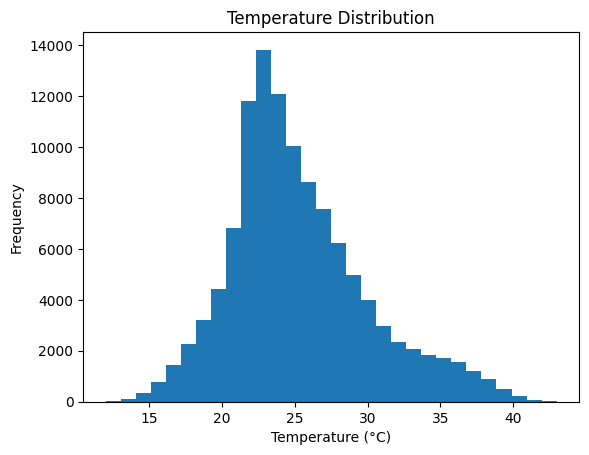

In [143]:
# Plotting a histogram to visualize the distribution of the 'tempC' column (temperature data).
wf['tempC'].plot(kind='hist', bins=30, title='Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.show()

year
2009    25.416210
2010    24.967808
2011    25.084817
2012    25.401753
2013    25.117009
2014    25.387100
2015    25.354566
2016    25.123634
2017    25.451027
2018    25.830023
2019    25.528311
2020    25.433629
2021    25.333219
Name: tempC, dtype: float64


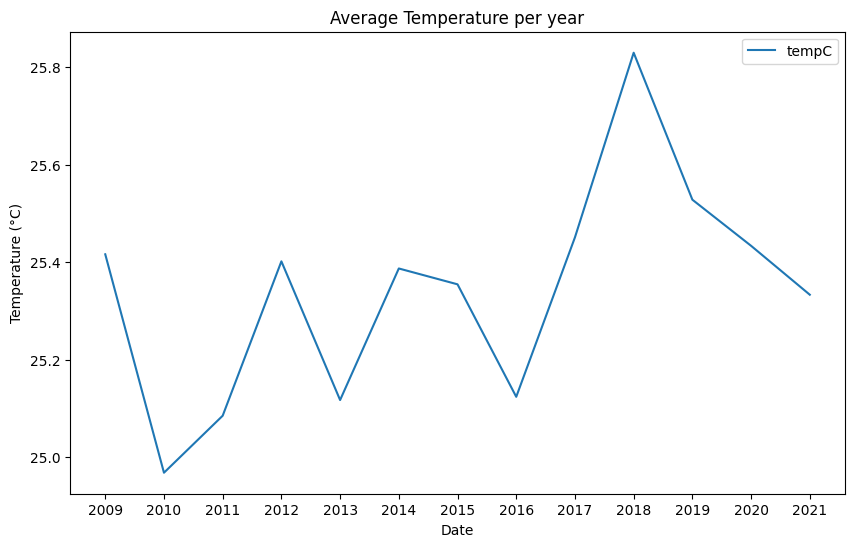

In [144]:
# Sorting the DataFrame by 'date_time' column
wf = wf.sort_values(by='date_time')

# Calculating the average temperature ('tempC') per year.
wfg = wf.groupby('year')['tempC'].mean()
print(wfg)

# Resetting the index for easier plotting and plotting a line graph of yearly average temperature.
wfg = wfg.reset_index()
wfg.plot(x='year', y='tempC', kind='line', figsize=(10, 6))

# Adding labels and title for the plot.
plt.xticks(wfg['year'].unique())
plt.title('Average Temperature per year')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()


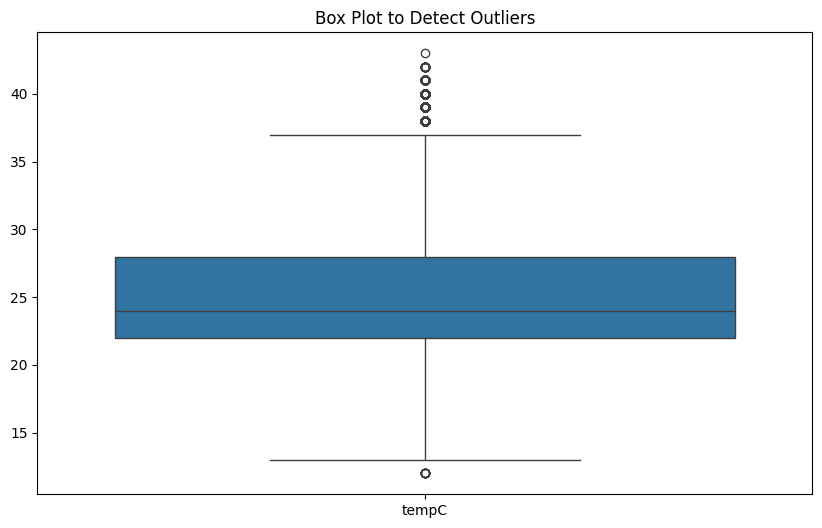

Number of outliers in Temperature: 1718
Original DataFrame shape: (113952, 16)
        year  tempC
1356    2009     38
1357    2009     38
1358    2009     38
1380    2009     38
1381    2009     38
...      ...    ...
107942  2021     39
107943  2021     39
107944  2021     39
107965  2021     38
107966  2021     38

[1718 rows x 2 columns]


In [145]:
# Plotting a boxplot for 'tempC' to visually detect outliers.
plt.figure(figsize=(10, 6))
sns.boxplot(data=wf[['tempC']])
plt.title('Box Plot to Detect Outliers')
plt.show()

# Calculating IQR and identifying outliers in 'tempC'.
Q1 = wf['tempC'].quantile(0.25)
Q3 = wf['tempC'].quantile(0.75)
IQR = Q3 - Q1
outliers_tempC = wf[(wf['tempC'] < (Q1 - 1.5 * IQR)) | (wf['tempC'] > (Q3 + 1.5 * IQR))]

# Printing the number of outliers and details of outlier rows.
print("Number of outliers in Temperature:", len(outliers_tempC))
print("Original DataFrame shape:", wf.shape)
print(outliers_tempC[['year', 'tempC']])





Original DataFrame shape: (113952, 16)
DataFrame without outliers shape: (112234, 16)
Number of outliers in Temperature: 112234
            date_time  maxtempC  mintempC  FeelsLikeC  HeatIndexC  WindChillC  \
0 2009-01-01 00:00:00        31        17          17          17          17   
1 2009-01-01 01:00:00        31        17          17          17          17   
2 2009-01-01 02:00:00        31        17          17          17          17   
3 2009-01-01 03:00:00        31        17          17          17          17   
4 2009-01-01 04:00:00        31        17          17          17          17   

   WindGustKmph  humidity  precipMM  pressure  tempC location  year  month  \
0             7        50       0.0      1013     17     pune  2009      1   
1             9        46       0.0      1013     17     pune  2009      1   
2            10        43       0.0      1013     17     pune  2009      1   
3            12        40       0.0      1013     17     pune  2009      

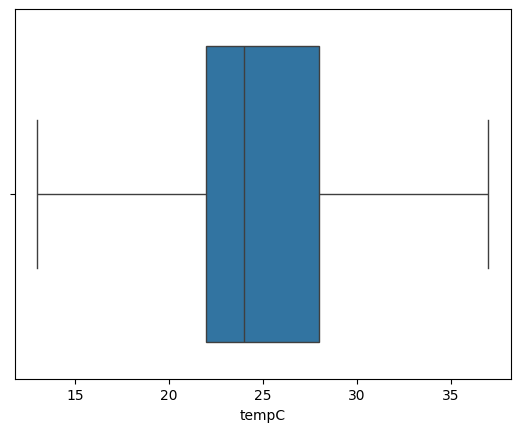

In [146]:
# Removing outliers from 'tempC' based on IQR thresholds and creating a new DataFrame.
wf_no_outliers = wf[(wf['tempC'] >= (Q1 - 1.5 * IQR)) & (wf['tempC'] <= (Q3 + 1.5 * IQR))]
wf_no_outliers.tail()

# Printing the shapes of the original and outlier-removed DataFrames for comparison.
print("Original DataFrame shape:", wf.shape)
print("DataFrame without outliers shape:", wf_no_outliers.shape)

# Plotting a boxplot of 'tempC' without outliers to confirm their removal.
sns.boxplot(x=wf_no_outliers['tempC'])

# Printing the number of rows in the outlier-free DataFrame and displaying the first few rows.
print("Number of outliers in Temperature:", len(wf_no_outliers))
print(wf_no_outliers.head())

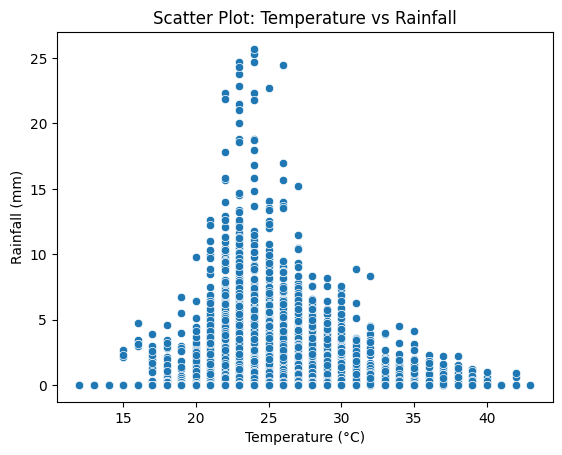

          tempC  precipMM
year                     
2009  25.416210  0.262340
2010  24.967808  0.269829
2011  25.084817  0.236416
2012  25.401753  0.155886
2013  25.117009  0.245959
2014  25.387100  0.207591
2015  25.354566  0.154749
2016  25.123634  0.259791
2017  25.451027  0.265982
2018  25.830023  0.188276
2019  25.528311  0.317146
2020  25.433629  0.302209
2021  25.333219  0.202489


In [147]:
# Plotting a scatter plot to visualize the relationship between temperature ('tempC') and rainfall ('precipMM').
sns.scatterplot(x='tempC', y='precipMM', data=wf)
plt.title('Scatter Plot: Temperature vs Rainfall')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rainfall (mm)')
plt.show()

# Calculating the yearly average for temperature ('tempC') and rainfall ('precipMM').
wfs =wf.groupby('year')[['tempC','precipMM']].mean()
print(wfs)


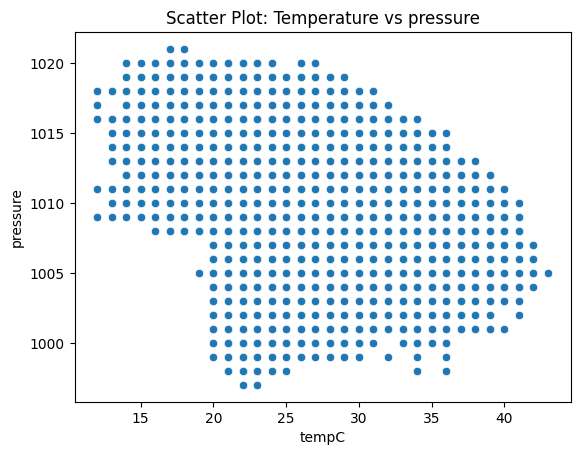

In [148]:
# Plotting a scatter plot to visualize the relationship between temperature ('tempC') and pressure.
sns.scatterplot(x='tempC', y='pressure', data=wf)
plt.title("Scatter Plot: Temperature vs pressure")
plt.show()


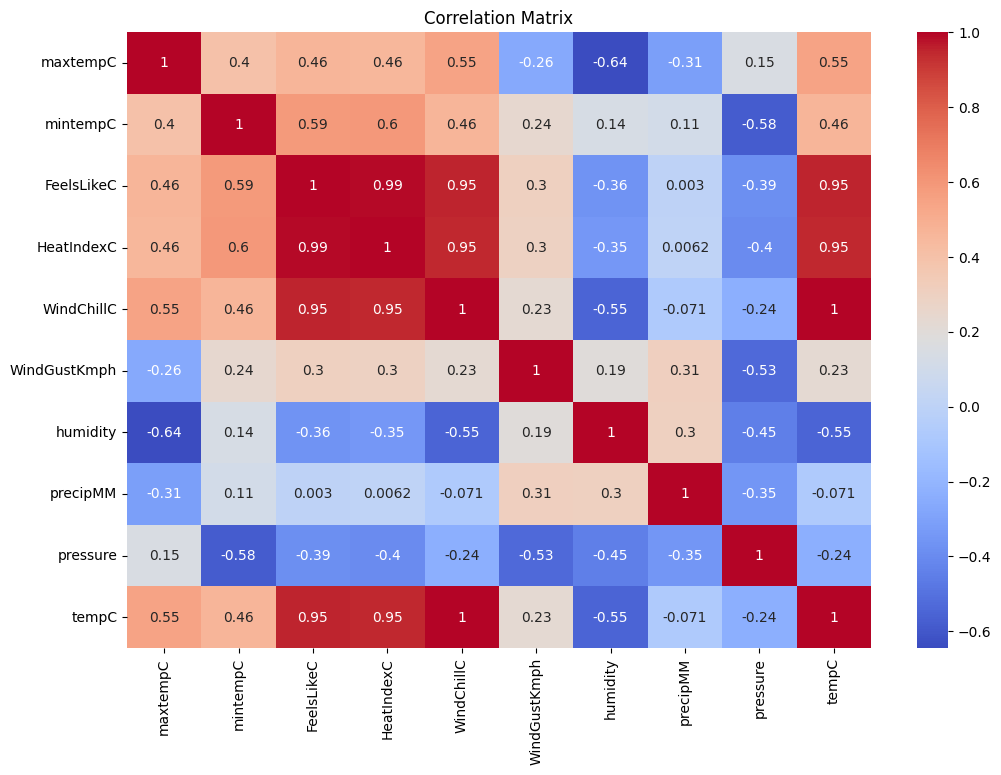

In [149]:
# Selecting only numeric columns from the DataFrame for correlation analysis.
numeric_data = wf.select_dtypes(include=['float64', 'int64'])

# Plotting a heatmap to visualize the correlation matrix of the numeric columns.
plt.figure(figsize=(12, 8))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [150]:
# Setting 'date_time' as the index and resampling data to daily averages for temperature, humidity, and pressure.
wf_no_outliers.set_index('date_time', inplace=True)
wf_daily_data = wf_no_outliers[['tempC', 'humidity', 'pressure']].resample('D').mean()

# Displaying the first 30 rows and the last few rows of the daily data.
print(wf_daily_data.head())
wf_daily_data.tail()

                tempC   humidity     pressure
date_time                                    
2009-01-01  22.541667  37.875000  1012.791667
2009-01-02  22.125000  44.000000  1013.750000
2009-01-03  22.583333  47.791667  1014.708333
2009-01-04  22.208333  52.791667  1013.583333
2009-01-05  22.458333  51.833333  1011.791667


,tempC,humidity,pressure
date_time,,,
2021-12-27,23.083333,44.208333,1014.708333
2021-12-28,22.833333,53.500000,1013.750000
2021-12-29,21.250000,53.333333,1014.083333
2021-12-30,21.250000,54.458333,1015.666667
2021-12-31,22.625000,48.416667,1016.333333


In [151]:
# # Converting 'tempC', 'humidity', and 'pressure' columns to integers and printing the updated data types.
wf_daily_data['tempC'] = wf_daily_data['tempC'].astype(int)
wf_daily_data['humidity'] = wf_daily_data['humidity'].astype(int)
wf_daily_data['pressure'] = wf_daily_data['pressure'].astype(int)
# print data types
print(wf_daily_data.dtypes)

tempC       int64
humidity    int64
pressure    int64
dtype: object


In [152]:
# Saving the daily resampled data to a CSV file named 'out.csv' without including the index.
wf_daily_data.to_csv('out.csv', index=False)


preprocessing

In [153]:
# Scaling 'tempC', 'humidity', and 'pressure' columns to a 0-1 range using MinMaxScaler.
scaler = MinMaxScaler()
wf_daily_data[['tempC', 'humidity', 'pressure']] = scaler.fit_transform(wf_daily_data[['tempC', 'humidity', 'pressure']])

# Creating lag features for 'tempC' and 'humidity' to capture temporal relationships.
wf_daily_data['temp_lag_1'] = wf_daily_data['tempC'].shift(1)
wf_daily_data['humidity_lag_1'] = wf_daily_data['humidity'].shift(1)
print(wf_daily_data.head())

# Backfilling missing values caused by lagging.
wf_daily_data.fillna(method = 'bfill',inplace=True)
wf_daily_data.head()

# Splitting the data into training (before 2019) and testing (after 2019) sets.
train = wf_daily_data[wf_daily_data.index <= pd.to_datetime('2019-01-01')]
test = wf_daily_data[wf_daily_data.index > pd.to_datetime('2019-01-01')]


               tempC  humidity  pressure  temp_lag_1  humidity_lag_1
date_time                                                           
2009-01-01  0.307692  0.306818      0.70         NaN             NaN
2009-01-02  0.307692  0.386364      0.75    0.307692        0.306818
2009-01-03  0.307692  0.420455      0.80    0.307692        0.386364
2009-01-04  0.307692  0.477273      0.75    0.307692        0.420455
2009-01-05  0.307692  0.465909      0.65    0.307692        0.477273


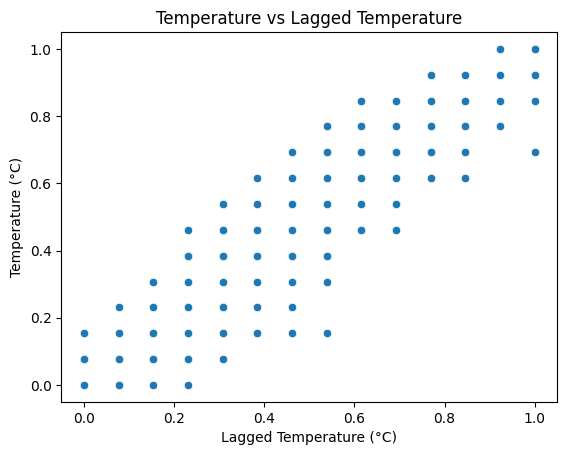

In [154]:
# Scatter plot for lagged features
sns.scatterplot(x=wf_daily_data['temp_lag_1'], y=wf_daily_data['tempC'])
plt.title("Temperature vs Lagged Temperature")
plt.xlabel("Lagged Temperature (°C)")
plt.ylabel("Temperature (°C)")
plt.show()


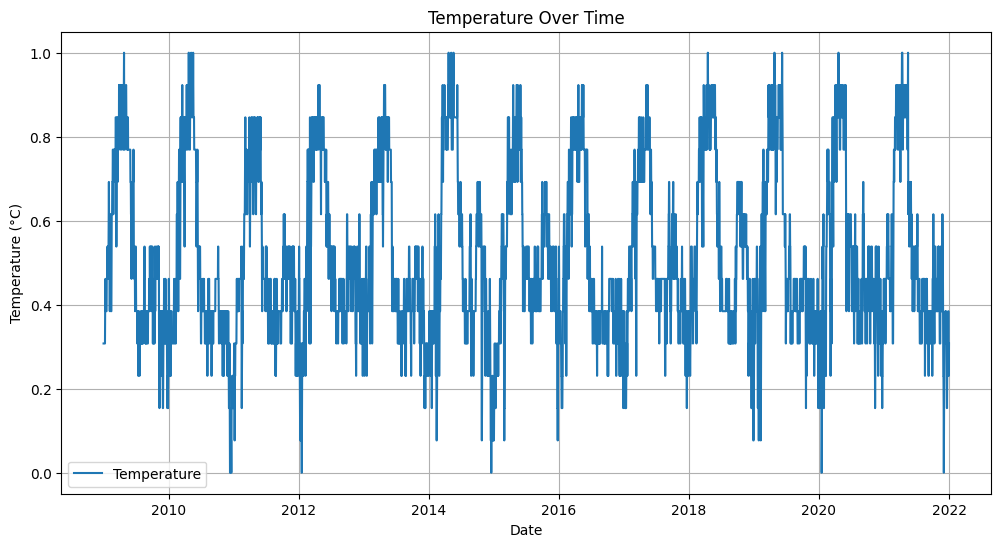

In [155]:
# Plotting temperature trends over time of original data.
plt.figure(figsize=(12, 6))
plt.plot(wf_daily_data.index,wf_daily_data['tempC'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()


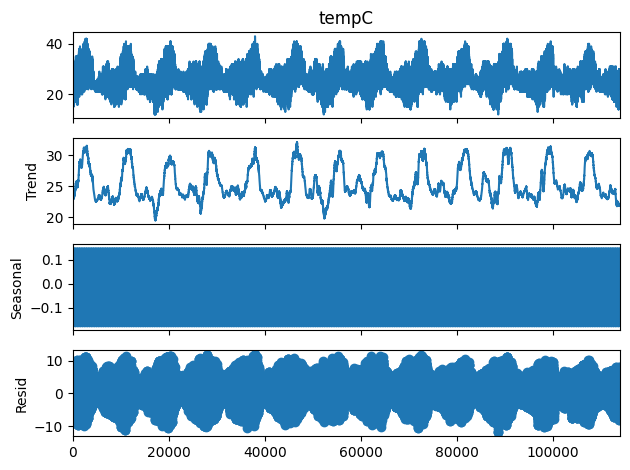

In [156]:
# Performing seasonal decomposition of temperature ('tempC') to analyze trends, seasonality, and residuals.
result = seasonal_decompose(wf['tempC'], model='additive', period=365)
result.plot()
plt.show()

ARIMA MODEL

In [157]:
# Function to check stationarity of a time series using the Augmented Dickey-Fuller (ADF) test.
def check_stationarity(series):
    """
    Check the stationarity of a time series using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    - series: pandas Series
        The time series to be tested for stationarity.

    Returns:
    - None: Prints the ADF statistic, p-value, and stationarity status.

    Key Steps:
    1. Perform the ADF test on the input series after removing NaN values.
    2. Print the ADF test statistic and the p-value.
    3. Determine stationarity based on the p-value:
       - If p-value < 0.05: The series is stationary.
       - Otherwise: The series is not stationary.
    """
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

# Checking stationarity of the 'tempC' column.
check_stationarity(wf['tempC'])

ADF Statistic: -8.60181633817182
p-value: 6.836621222378553e-14
The series is stationary.


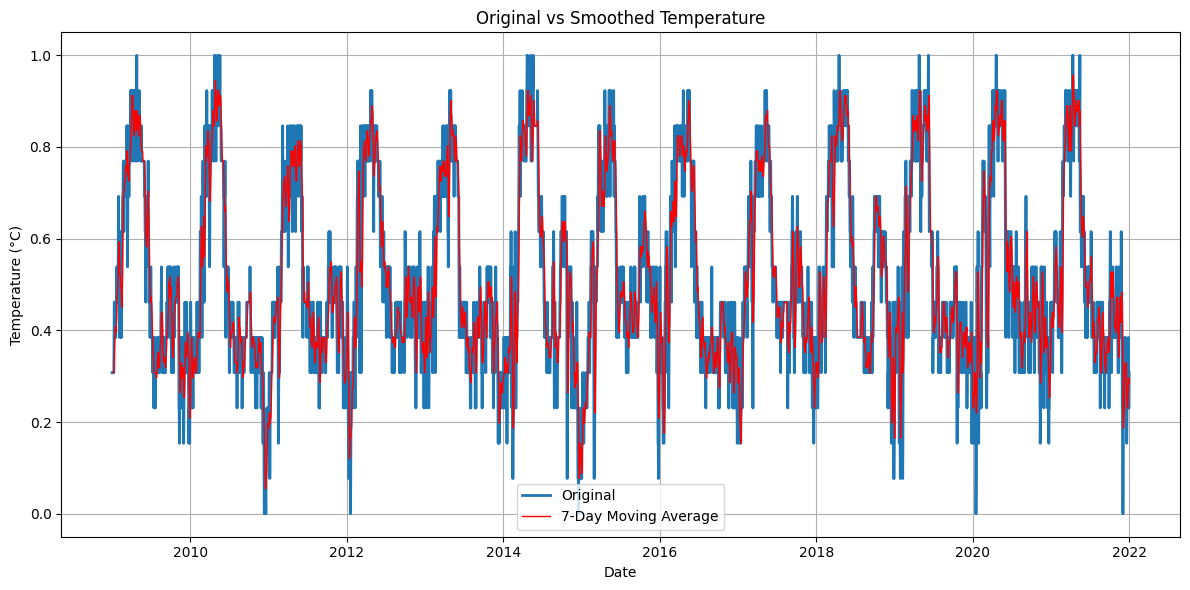

In [158]:
#Calculating a 7-day moving average for 'tempC' to to smooth the temperatue data
temperature_rolling = wf_daily_data['tempC'].rolling(window=7).mean()

#Plotting the original temperature data and the 7-day moving average
plt.figure(figsize=(12, 6))
plt.plot(wf_daily_data.index, wf_daily_data['tempC'], label='Original', linewidth=2)
plt.plot(wf_daily_data.index, temperature_rolling, label='7-Day Moving Average', color='red', linewidth=1)
plt.title('Original vs Smoothed Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()




<Figure size 1200x600 with 0 Axes>

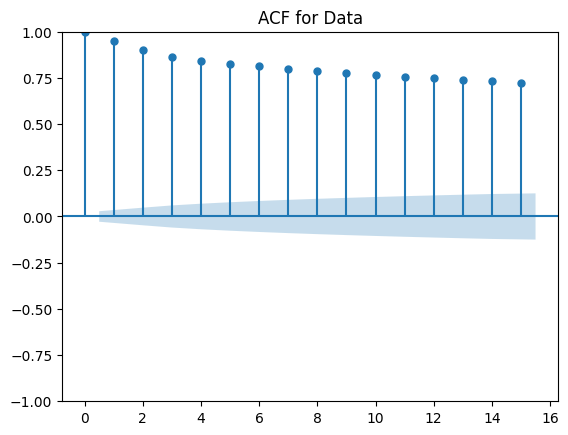

<Figure size 1200x600 with 0 Axes>

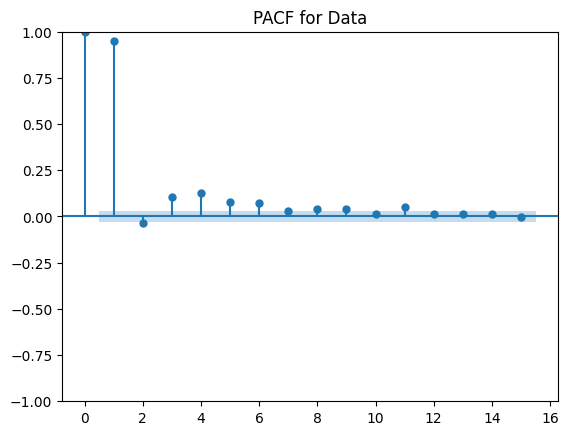

In [159]:
#Plotting the ACF to analyze lag dependencies in the data
plt.figure(figsize=(12, 6))
plot_acf(wf_daily_data['tempC'], lags=15)
plt.title('ACF for Data')
plt.show()

#Plotting the PACF to analyze direct correlations with lagged data
plt.figure(figsize=(12, 6))
plot_pacf(wf_daily_data['tempC'], lags=15)
plt.title('PACF for Data')
plt.show()

In [160]:
#Using auto-arima to automatically find the best ARIMA model for the training data('tempC')
#It searches through various combinations of p, d & q parameters basec on AIC(Akaike Information Criterion)
auto_model = auto_arima(train['tempC'],
                        start_p=0, start_q=0, #Starting values for p and q
                        max_p=5, max_q=5, #Maximum values for p and q
                        d=None, #Automatically determine the differencing oredr
                        seasonal=False, #Non-seasonal Arima model
                        stepwise=True, #Stepwise search to speedup the process
                        trace=True, #Display progress during model selection
                        error_action='ignore', #Ignore erorrs during the search
                        suppress_warnings=True, #Suppress waring messages
                        max_order=None, #NO limit on the sum of p and q
                        information_criterion='aic' #Use AIC to choose the best model
                        )

#Printing a summary of the selected ARiMA model
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6027.736, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1503.837, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10039.722, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=2.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-10132.545, Time=0.58 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1784.926, Time=1.21 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=6.00 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-10238.321, Time=1.28 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-3817.682, Time=1.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-10261.911, Time=2.54 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-10259.752, Time=2.36 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-10259.471, Time=5.30 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-10255.638, Time=1.57 sec
 ARIMA(3,0,2)(0,0,0)[0]         

In [161]:
#Building an ARIMA model with order (2, 0, 2) and including exogenous variables
model = ARIMA(train['tempC'], order=(2, 0, 2),exog=train[['humidity', 'pressure','temp_lag_1','humidity_lag_1']])
model_fit = model.fit()

#Printing the summary of the fitted ARIMA model
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                  tempC   No. Observations:                 3653
Model:                 ARIMA(2, 0, 2)   Log Likelihood                5386.873
Date:                Mon, 06 Jan 2025   AIC                         -10753.746
Time:                        18:41:19   BIC                         -10691.713
Sample:                    01-01-2009   HQIC                        -10731.655
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0252      0.007      3.777      0.000       0.012       0.038
humidity          -0.3357      0.012    -28.996      0.000      -0.358      -0.313
pressure          -0.0119      0.005

In [162]:
#Forecasting  for the test period using the fitted model and exogenous variables
forecast_steps_1 = len(test)
long_term_forecast = model_fit.get_forecast(steps=forecast_steps_1,exog=test[['humidity', 'pressure','temp_lag_1','humidity_lag_1']])
long_term_forecast_mean = long_term_forecast.predicted_mean
conf_int_1= long_term_forecast.conf_int(alpha = 0.68)

# Extract lower and upper bounds
lower_bound_1 = conf_int_1.iloc[:, 0]
upper_bound_1 = conf_int_1.iloc[:, 1]

forecast_index_1 = pd.date_range(start=test.index[0] + pd.Timedelta(days=1), periods=forecast_steps_1, freq='D')

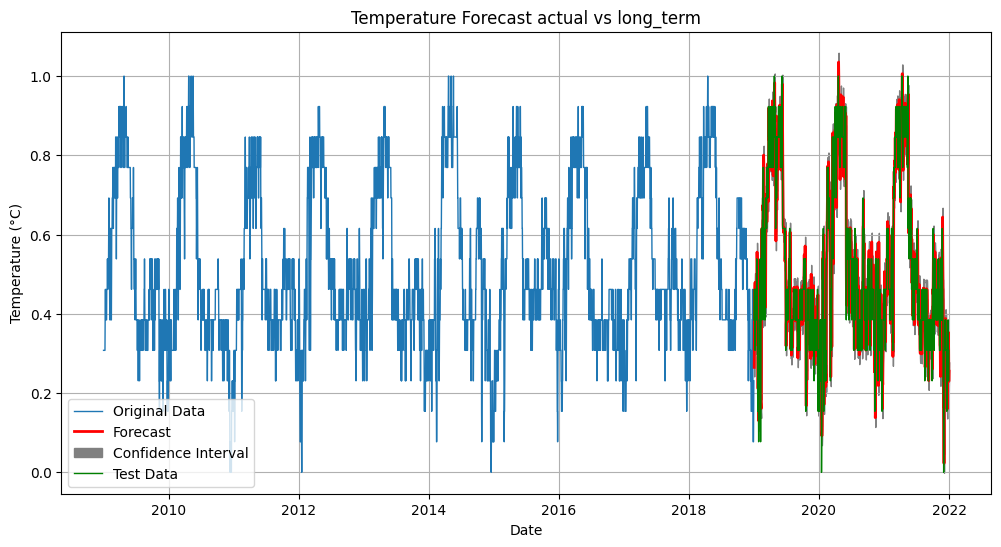

,predicted_mean
2019-01-02,0.264702
2019-01-03,0.383937
2019-01-04,0.458625
2019-01-05,0.441945
2019-01-06,0.460163
...,...
2021-12-27,0.300252
2021-12-28,0.352943
2021-12-29,0.309205
2021-12-30,0.229187


In [163]:
#Plotting the origonal training data, forecasted values, and actual test adata for comparsion
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['tempC'], label='Original Data', linewidth=1)
plt.plot(forecast_index_1, long_term_forecast.predicted_mean, label='Forecast', color='red', linewidth=2)
plt.fill_between(forecast_index_1, lower_bound_1, upper_bound_1, color='gray', label='Confidence Interval')
plt.plot(test.index, test['tempC'], label='Test Data', color='green', linewidth=1)
plt.title('Temperature Forecast actual vs long_term')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

#Displaying the forecasted values
long_term_forecast.predicted_mean


In [164]:
# Define the number of steps for short-term forecasting (e.g., next 7 days).
forecast_steps_2 = 7
# Generate the short-term forecast using the ARIMA model with exogenous variables.
short_term_forecast = model_fit.get_forecast(steps=forecast_steps_2,exog=test[['humidity', 'pressure','temp_lag_1','humidity_lag_1']][:forecast_steps_2])
# Extract the mean (predicted values) from the forecast.
short_term_forecast_mean = short_term_forecast.predicted_mean
# Calculate the 68% confidence intervals for the short-term forecast.
conf_int_2 = short_term_forecast.conf_int(alpha = 0.68)
#Extract lower and upper bounds
lower_bound_2 = conf_int_2.iloc[:, 0]
upper_bound_2 = conf_int_2.iloc[:, 1]

#Creating a date range for the forecasted values to align with the test set
forecast_index_2 = pd.date_range(start=test.index[0] + pd.Timedelta(days=1), periods=forecast_steps_2, freq='D')


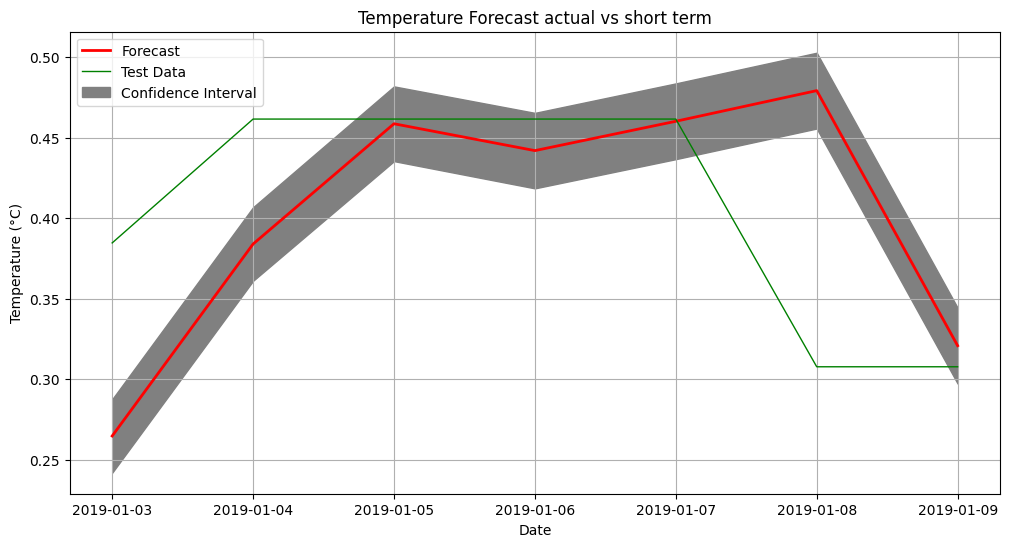

In [165]:
#Plotting the origonal training data, short_term_forecast values, and actual test adata for comparsion
plt.figure(figsize=(12, 6))
#plt.plot(train.index, train['tempC'], label='Original Data', linewidth=1)
plt.plot(forecast_index_2, short_term_forecast.predicted_mean, label='Forecast', color='red', linewidth=2)
plt.plot(test.index[1:8], test['tempC'][:forecast_steps_2], label='Test Data', color='green', linewidth=1)
plt.fill_between(forecast_index_2, lower_bound_2, upper_bound_2, color='gray', label='Confidence Interval')
plt.title('Temperature Forecast actual vs short term')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

#Displaying the forecasted values
short_term_forecast


In [166]:
print('long_term_forecast')
#Calculating and printing thr evalution metrics for the forecast: MAE, RMSE, R^2
mae = mean_absolute_error(test['tempC'], long_term_forecast.predicted_mean)
print("MAE:", mae)# Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test['tempC'], long_term_forecast.predicted_mean))
print("RMSE:", rmse)# Root Mean Squared Error
r2 = r2_score(test['tempC'], long_term_forecast.predicted_mean)
print("R²:", r2)# Coefficient of Determination


long_term_forecast
MAE: 0.046748429841852
RMSE: 0.06321175440368819
R²: 0.9059778209296673


In [167]:
print('SHORT_TERM_FORECAST')
#Calculating and printing thr evalution metrics for the short_term_forecast: MAE, RMSE, R^2
test_short = test[1:8]['tempC']
mae = mean_absolute_error(test_short, short_term_forecast.predicted_mean)
print("MAE:", mae)# Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test_short, short_term_forecast.predicted_mean))
print("RMSE:", rmse)# Root Mean Squared Error
r2 = r2_score(test_short, short_term_forecast.predicted_mean)
print("R²:", r2)# Coefficient of Determination


SHORT_TERM_FORECAST
MAE: 0.09782234660712359
RMSE: 0.12065121809793217
R²: -2.172214966961347


FACEBOOK PROPHET MODEL

In [168]:
# Creating a new DataFrame from thr training data and removing the lag columns
wf_pro = pd.DataFrame(train)
wf_pro.drop(columns=['temp_lag_1', 'humidity_lag_1'],inplace = True)
# Adding a 'ds' column with datetime from the ndex and a 'y' column with the target variable('tempC')
wf_pro['ds'] = pd.to_datetime(train.index)
wf_pro['y'] = train['tempC']

# Displaying the first few steps of the processed DataFrame
wf_pro.head()

,tempC,humidity,pressure,ds,y
date_time,,,,,
2009-01-01,0.307692,0.306818,0.70,2009-01-01,0.307692
2009-01-02,0.307692,0.386364,0.75,2009-01-02,0.307692
2009-01-03,0.307692,0.420455,0.80,2009-01-03,0.307692
2009-01-04,0.307692,0.477273,0.75,2009-01-04,0.307692
2009-01-05,0.307692,0.465909,0.65,2009-01-05,0.307692


In [169]:
def prepare_prophet_data(train, test):
    """
    Prepares the training and test datasets for Prophet by creating 'ds' and 'y' columns
    and removing unnecessary lag columns.

    Parameters:
    - train: DataFrame containing the training data.
    - test: DataFrame containing the test data.

    Returns:
    - wf_pro: Processed training DataFrame with 'ds' and 'y' columns.
    - wf_pro_test: Processed test DataFrame with 'ds' and 'y' columns.
    """
    # Processing the train data
    wf_pro = pd.DataFrame(train)
    wf_pro.drop(columns=['temp_lag_1', 'humidity_lag_1'], inplace=True)  # Removing lag columns
    wf_pro['ds'] = pd.to_datetime(train.index)  # Adding 'ds' column with datetime
    wf_pro['y'] = train['tempC']  # Adding 'y' column with the target variable

    # Processing the test data
    wf_pro_test = pd.DataFrame(test)
    wf_pro_test.drop(columns=['temp_lag_1', 'humidity_lag_1'], inplace=True)  # Removing lag columns
    wf_pro_test['ds'] = pd.to_datetime(test.index)  # Adding 'ds' column with datetime
    wf_pro_test['y'] = test['tempC']  # Adding 'y' column with the target variable

    # Returning the processed DataFrames
    return wf_pro, wf_pro_test


In [170]:
#calling the function to get the processed train and test dataset
wf_pro, wf_pro_test = prepare_prophet_data(train, test)

In [171]:
# Initializing and fitting the prophet model on the training data
model = Prophet(interval_width = 0.68)
model.fit(wf_pro)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnt6t8/yrzpbu59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnt6t8/et227olu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31229', 'data', 'file=/tmp/tmprjwnt6t8/yrzpbu59.json', 'init=/tmp/tmprjwnt6t8/et227olu.json', 'output', 'file=/tmp/tmprjwnt6t8/prophet_modelok37kgov/prophet_model-20250106184121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


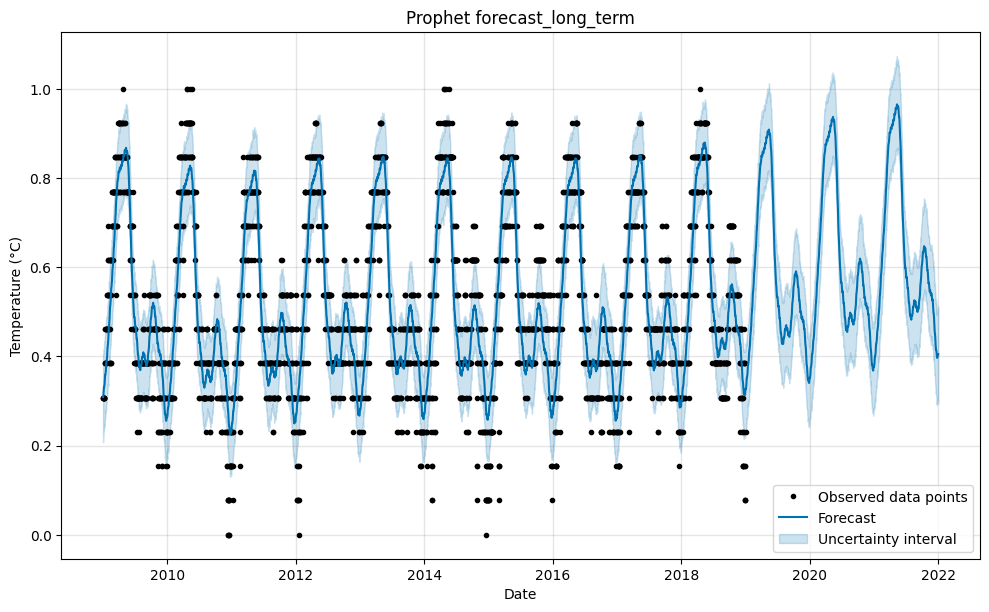

In [172]:

# Creating a future DataFrame for predictions, with the same frequency as the test data
forecast_pro_1=len(wf_pro_test)
future_long_term = model.make_future_dataframe(periods=forecast_pro_1,freq='D')

# Generating the predictions for the future dates
forecast_long_term = model.predict(future_long_term)

# Displaying the key columns of the forecast, including predicted values('yhat') and confidence intervals
forecast_long_term[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()

# Extracting true values and predictions for evaluation
y_true = wf_pro_test['y'].values  # Actual test values
y_pred = forecast_long_term['yhat'][-len(wf_pro_test):].values # Predicted values

#combining training and test data for visulization
wf_prophet = pd.concat([wf_pro,wf_pro_test])

#Plotting the Prophet forecast with observed data
prophet_plot_1 = model.plot(forecast_long_term, include_legend=True)
plt.title("Prophet forecast_long_term")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

In [173]:
# Creating a future DataFrame for predictions, with the same frequency as the test data
forecast_pro_2= 7
future_short_term = model.make_future_dataframe(periods=forecast_pro_2,freq='D')

# Generating the predictions for the future dates
forecast_short_term = model.predict(future_short_term)

# Displaying the key columns of the forecast, including predicted values('yhat') and confidence intervals
forecast_short_term[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()

# Extracting true values and predictions for evaluation
y_true = wf_pro_test[1:8]['y'].values  # Actual test values
y_pred = forecast_short_term['yhat'][:forecast_pro_2].values # Predicted values

#combining training and test data for visulization
wf_prophet = pd.concat([wf_pro,wf_pro_test])


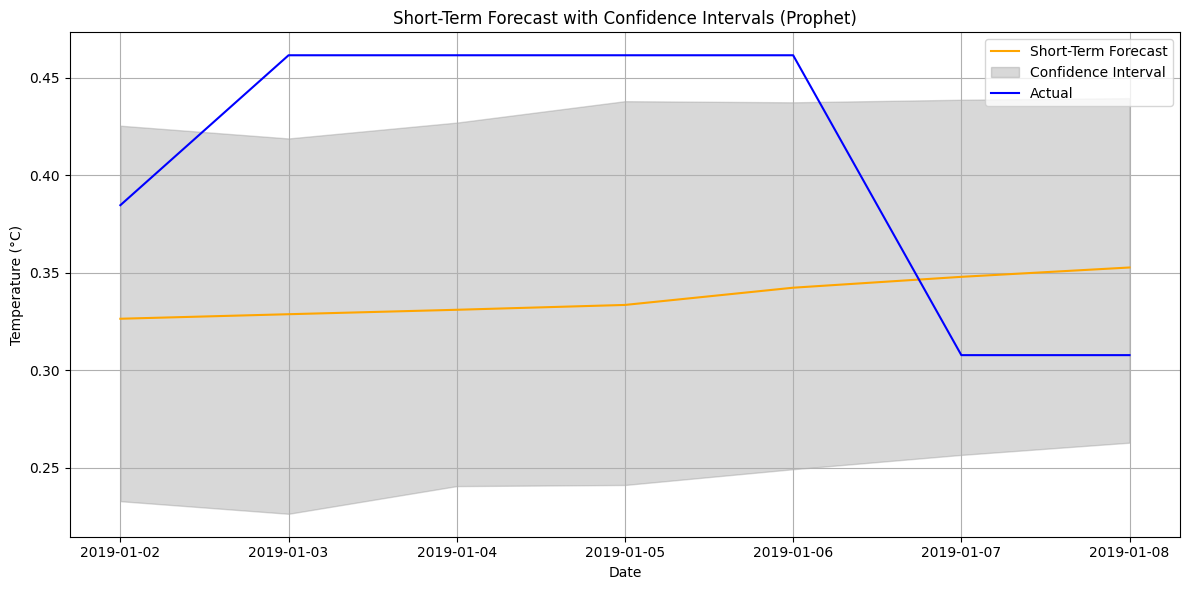

In [174]:


# Ensure short_forecast is for the next 7 days (short-term forecast)
short_forecast = forecast_short_term.tail(7)  # Get the last 7 rows from forecast_short_term

# Merge with actual test data for the same period
short_forecast_actual = short_forecast.merge(wf_pro_test.head(7), on='ds', how='left')

# Plot the Short-Term Forecast with Confidence Intervals
plt.figure(figsize=(12, 6))

# Plot the forecasted values
plt.plot(short_forecast['ds'], short_forecast['yhat'], label='Short-Term Forecast', color='orange')

# Plot the confidence intervals
plt.fill_between(
    short_forecast['ds'],
    short_forecast['yhat_lower'],
    short_forecast['yhat_upper'],
    color='gray', alpha=0.3, label='Confidence Interval'
)

# Plot the actual values
plt.plot(short_forecast_actual['ds'], short_forecast_actual['y'], label='Actual', color='blue')

# Add title and labels
plt.title('Short-Term Forecast with Confidence Intervals (Prophet)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


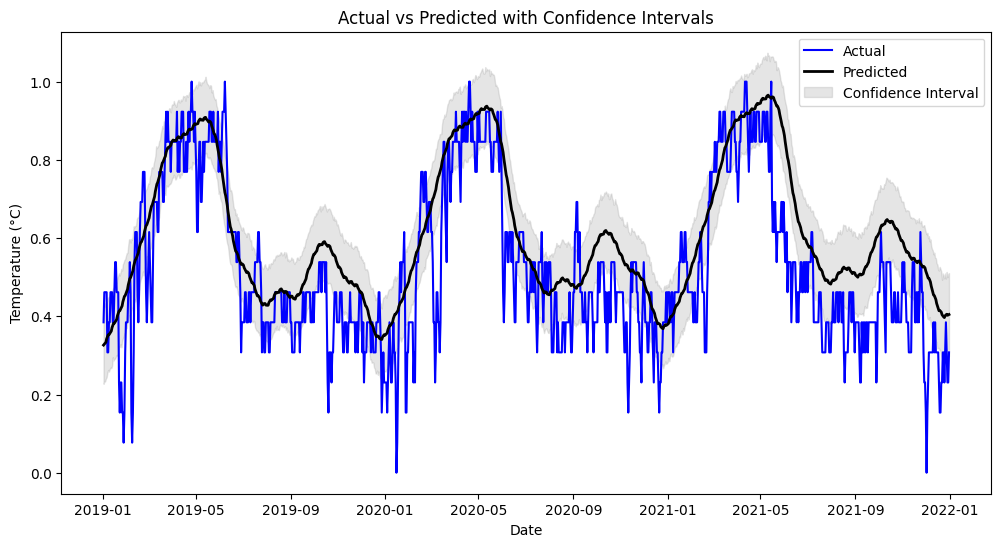

,yhat
0,0.308907
1,0.310593
2,0.312552
3,0.320928
4,0.326102
...,...
4743,0.403508
4744,0.405147
4745,0.402457
4746,0.403435


In [175]:
# Merge actual test data with the forecasted values, including the cinfindence intervals
forecast_actual = pd.merge(wf_pro_test, forecast_long_term[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Plot actual vs predicted values along with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(forecast_actual['ds'], forecast_actual['y'], label='Actual', color='blue')
plt.plot(forecast_actual['ds'], forecast_actual['yhat'], label='Predicted', color='black',linewidth=2)
plt.fill_between(forecast_actual['ds'],
                 forecast_actual['yhat_lower'],
                 forecast_actual['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title("Actual vs Predicted with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# Displaying the predicted values ('yhat') from the forecast
forecast_long_term['yhat']

In [176]:
# Calculating and printing the performance metrics to evaluate the model
print('LONG_TERM_FORECAST')
print("Mean Squared Error (MSE):", mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast_long_term['yhat']))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = wf_prophet["y"], y_pred = forecast_long_term['yhat']))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast_long_term['yhat'])))
print("R-squared (R²):", r2_score(y_true = wf_prophet["y"], y_pred = forecast_long_term['yhat']))


# Calculating and printing the performance metrics to evaluate the model
print('SHORT_TERM_FORECAST')
print("Mean Squared Error (MSE):", mean_squared_error(y_true = short_forecast_actual["y"], y_pred = short_forecast['yhat']))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = short_forecast_actual["y"], y_pred = short_forecast['yhat']))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = short_forecast_actual["y"], y_pred = short_forecast['yhat'])))
print("R-squared (R²):", r2_score(y_true = short_forecast_actual["y"], y_pred = short_forecast['yhat']))



LONG_TERM_FORECAST
Mean Squared Error (MSE): 0.011477446767786083
Mean Absolute Error (MAE): 0.08179121184711043
Root Mean Squared Error (RMSE): 0.10713284635342274
R-squared (R²): 0.7181979238210471
SHORT_TERM_FORECAST
Mean Squared Error (MSE): 0.01033700959918327
Mean Absolute Error (MAE): 0.09345233097303761
Root Mean Squared Error (RMSE): 0.10167108536444013
R-squared (R²): -1.2526520129167573


cnn_lstm

(3563, 90, 4)
(3563,)
(1005, 90, 4)
(1005,)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 86, 128)             │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,389 (368.71 KB)

 Trainable params: 94,389 (368.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0378 - mae: 0.1360 - val_loss: 0.0110 - val_mae: 0.0792
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0101 - mae: 0.0757 - val_loss: 0.0124 - val_mae: 0.0845
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 0.0100 - mae: 0.0753 - val_loss: 0.0100 - val_mae: 0.0761
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0086 - mae: 0.0702 - val_loss: 0.0099 - val_mae: 0.0773
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - loss: 0.0085 - mae: 0.0699 - val_loss: 0.0091 - val_mae: 0.0724
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.0078 - mae: 0.0671 - val_loss: 0.0093 - val_mae: 0.0755
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 0.0085 - mae: 0.0708 - val_loss: 0.0086 - val_mae: 0.0703
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.0072 - mae: 0.0643 - val_loss: 0.0081 - val_mae: 0.0687
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s

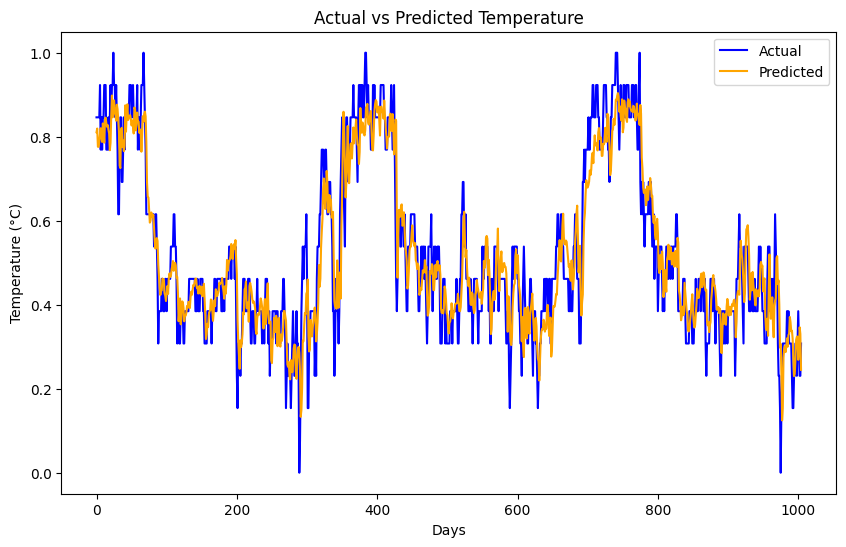

In [177]:
# Function to create sequences of input feature and target valuess for the time series data
def sequence_creating(data,seq_len,target_col = 'tempC'):
  X, y = [], []
  for i in range(len(data) - seq_len):
    X.append(data.iloc[i:i+seq_len, 1:].values)# Extracting feature sequences
    y.append(data.iloc[i+seq_len][target_col])# Extracting corresponding targets
  return np.array(X), np.array(y)

# Setting the sequence lenght for thr model and creatin train/test dataset
sequence_length = 90
X_train, y_train = sequence_creating(train,sequence_length)
X_test, y_test = sequence_creating(test,sequence_length)

# Printing the shapes of the input features and target arrays
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#Building a CNN-LSTM model for time series prediction
model = Sequential()

# Convolution layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, X_train.shape[2])))

model.add(MaxPooling1D(pool_size=2)) # Max pooling layer

model.add(LSTM(100, activation='relu', return_sequences=False)) # LSTM layer

model.add(Flatten()) # Flattering the output

model.add(Dense(1)) # Dense layer for final output

# Compiling the modle with Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Displaying the model summary
model.summary()

# Training the model on training data and validating on test data
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predicting temperature values using the test data
y_pred = model.predict(X_test)

# Plotting actual vs predicted temperature values for comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='orange')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()



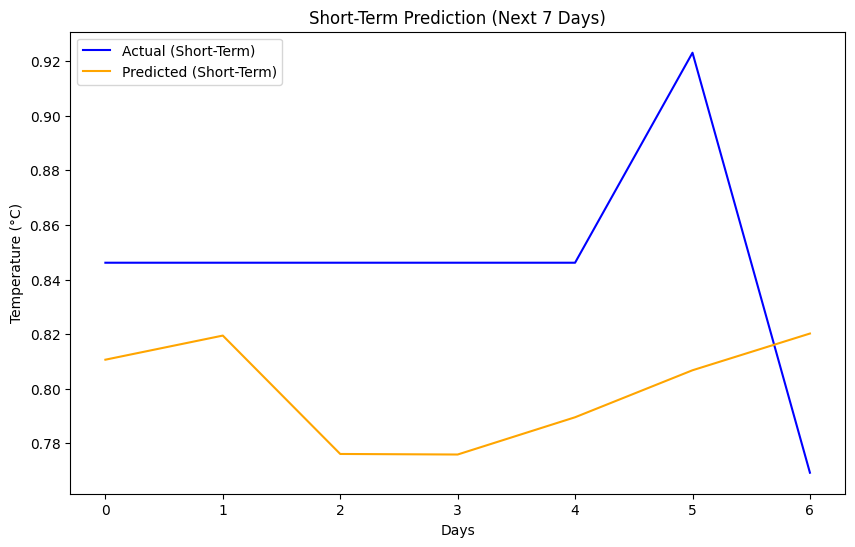

In [178]:
# Predict for the next n days (short-term)
short_term_horizon = 7  # Number of days for short-term prediction
y_short_term_pred = y_pred[:short_term_horizon]

# Plot short-term predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test[:short_term_horizon], label='Actual (Short-Term)', color='blue')
plt.plot(y_short_term_pred.flatten(), label='Predicted (Short-Term)', color='orange')
plt.title('Short-Term Prediction (Next 7 Days)')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


In [179]:
# Ensure y_pred is sliced to match y_test[:short_term_horizon]
y_pred_short = y_pred[:short_term_horizon]
y_actual_short = y_test[:short_term_horizon]

In [180]:
# Calculating and printing evaluation metric for the modles performance on the test dat
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred) # Mean Absolute Error
r2 = r2_score(y_test, y_pred) # Coefficient of Determination

print("Test RMSE: ", rmse)
print("Test MAE: ", mae)
print("R²:", r2)

Test RMSE:  0.0840326568613249
Test MAE:  0.06478970694019565
R²: 0.8332661353094146


In [181]:
# Calculating and printing evaluation metric for the modles performance on the test dat
rmse = np.sqrt(mean_squared_error(y_actual_short, y_pred_short)) # Root Mean Squared Error
mae = mean_absolute_error(y_actual_short, y_pred_short) # Mean Absolute Error
r2 = r2_score(y_actual_short, y_pred_short) # Coefficient of Determination

print("Test RMSE: ", rmse)
print("Test MAE: ", mae)
print("R²:", r2)

Test RMSE:  0.06670759093857861
Test MAE:  0.0609168613349999
R²: -1.6321174404422005


ARIMA MODEL FOR MoNSOON SEASON

In [182]:
#setting the index with date_time and seperating the monsoon data
wf.set_index('date_time', inplace=True)
wf_season_month = wf[['year','month','precipMM','humidity','pressure']]
wf_season_month.head()

,year,month,precipMM,humidity,pressure
date_time,,,,,
2009-01-01 00:00:00,2009,1,0.0,50,1013
2009-01-01 01:00:00,2009,1,0.0,46,1013
2009-01-01 02:00:00,2009,1,0.0,43,1013
2009-01-01 03:00:00,2009,1,0.0,40,1013
2009-01-01 04:00:00,2009,1,0.0,38,1013


In [183]:
#getting the info of the data
wf_season_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113952 entries, 2009-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   year      113952 non-null  int32  
 1   month     113952 non-null  int32  
 2   precipMM  113952 non-null  float64
 3   humidity  113952 non-null  int64  
 4   pressure  113952 non-null  int64  
dtypes: float64(1), int32(2), int64(2)
memory usage: 4.3 MB


In [184]:
# function to get the season column
def get_season(month):
    if month in [3, 4, 5]:
        return "summer"
    elif month in [6,7,8]:
        return "rainy"
    elif month in [9,10,11,]:
        return "spring"
    elif month in [12, 1, 2]:
        return "winter"
    else:
        return "Unknown"
#ipython-input-366-2d1aba2fb642


In [185]:
#calling the function
wf_season_month['season'] = wf_season_month['month'].apply(get_season)
wf_season_month.tail()

,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2021-12-31 19:00:00,2021,12,0.0,42,1016,winter
2021-12-31 20:00:00,2021,12,0.0,43,1017,winter
2021-12-31 21:00:00,2021,12,0.0,44,1018,winter
2021-12-31 22:00:00,2021,12,0.0,46,1017,winter
2021-12-31 23:00:00,2021,12,0.0,47,1017,winter


In [186]:
# Filter the data for the rainy season and display the first few rows.
monsoon_data = wf_season_month[wf_season_month['season'] == 'rainy']
monsoon_data.head()

,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2009-06-01 00:00:00,2009,6,0.0,90,1007,rainy
2009-06-01 01:00:00,2009,6,0.0,91,1007,rainy
2009-06-01 02:00:00,2009,6,0.0,92,1007,rainy
2009-06-01 03:00:00,2009,6,0.0,94,1007,rainy
2009-06-01 04:00:00,2009,6,0.0,84,1007,rainy


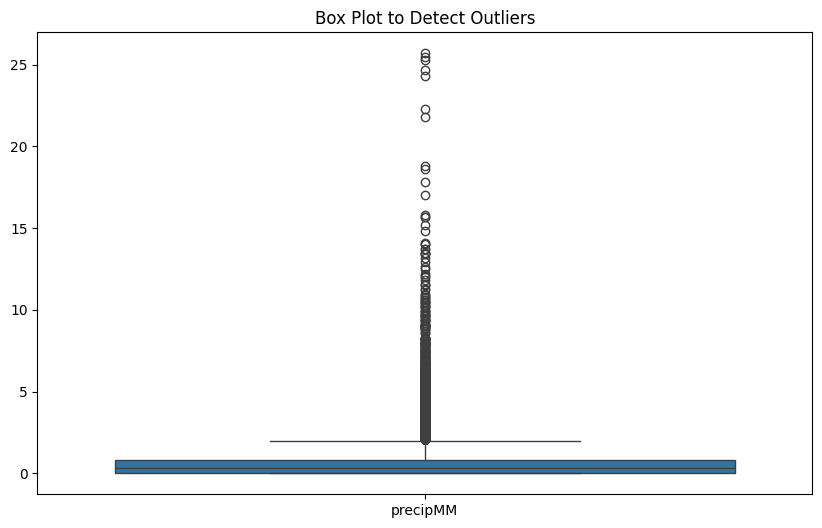

In [187]:
#plotting the outlier box plot using seborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=monsoon_data[['precipMM']])
plt.title('Box Plot to Detect Outliers')
plt.show()
# Calculate the first (Q1) and third (Q3) quartiles for rainfall (precipMM) in the rainy season.
# Compute the interquartile range (IQR) to identify the spread of the middle 50% of the data.
Q1 = monsoon_data['precipMM'].quantile(0.25)
Q3 = monsoon_data['precipMM'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers in rainfall where values are below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
outliers_precipMM = mansoon_data[(monsoon_data['precipMM'] < (Q1 - 1.5 * IQR)) | (monsoon_data['precipMM'] > (Q3 + 1.5 * IQR))]

In [188]:
# Print the total number of rainfall outliers detected.
print("Number of outliers in Temperature:", len(outliers_precipMM))

Number of outliers in Temperature: 2142


In [189]:
# Print the original dataset's shape and display the year and rainfall values for the outliers.
print("Original DataFrame shape:", monsoon_data.shape)
print(outliers_precipMM[['year', 'precipMM']])

Original DataFrame shape: (28704, 6)
                     year  precipMM
date_time                          
2009-06-06 15:00:00  2009       5.5
2009-06-20 06:00:00  2009       2.1
2009-06-20 08:00:00  2009       3.1
2009-06-20 09:00:00  2009       4.2
2009-06-20 10:00:00  2009       2.1
...                   ...       ...
2021-08-31 07:00:00  2021       3.8
2021-08-31 08:00:00  2021       3.4
2021-08-31 09:00:00  2021       3.3
2021-08-31 10:00:00  2021       3.2
2021-08-31 11:00:00  2021       2.8

[2142 rows x 2 columns]


In [190]:
# Remove outliers from the rainfall data and display the last few rows of the cleaned dataset.
wf_M= monsoon_data[(monsoon_data['precipMM'] >= (Q1 - 1.5 * IQR)) & (monsoon_data['precipMM'] <= (Q3 + 1.5 * IQR))]
wf_M.tail()

,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2021-08-31 19:00:00,2021,8,0.7,83,1007,rainy
2021-08-31 20:00:00,2021,8,0.5,85,1008,rainy
2021-08-31 21:00:00,2021,8,0.5,86,1008,rainy
2021-08-31 22:00:00,2021,8,0.4,87,1008,rainy
2021-08-31 23:00:00,2021,8,0.5,87,1008,rainy


Number of outliers in Temperature: 26562


,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2009-06-01 00:00:00,2009,6,0.0,90,1007,rainy
2009-06-01 01:00:00,2009,6,0.0,91,1007,rainy
2009-06-01 02:00:00,2009,6,0.0,92,1007,rainy
2009-06-01 03:00:00,2009,6,0.0,94,1007,rainy
2009-06-01 04:00:00,2009,6,0.0,84,1007,rainy


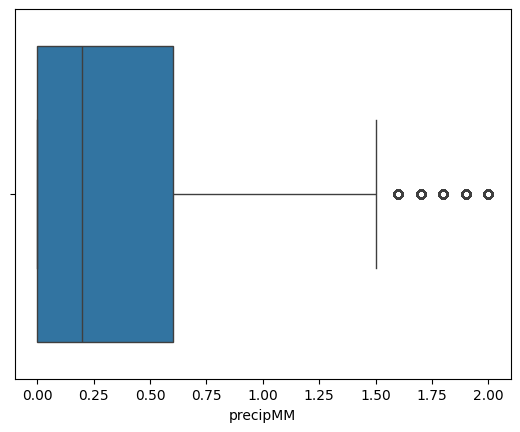

In [191]:
# Plot a boxplot to visualize rainfall distribution after removing outliers.
sns.boxplot(x=wf_M['precipMM'])
# Print the number of records in the cleaned dataset and display the first few rows.
print("Number of outliers in Temperature:", len(wf_M))
wf_M.head()


In [192]:
# Resample the rainfall, humidity, and pressure data to daily averages and display the first few rows.
wf_monsoon = wf_M[['precipMM','humidity','pressure']].resample('D').mean()
wf_monsoon.head()

,precipMM,humidity,pressure
date_time,,,
2009-06-01,0.087500,67.375000,1007.083333
2009-06-02,0.150000,67.958333,1008.000000
2009-06-03,0.066667,68.375000,1008.958333
2009-06-04,0.133333,72.625000,1007.333333
2009-06-05,0.170833,76.041667,1005.000000


In [193]:
# Scale the selected columns and store the result in a temporary variable
scaled_data = scaler.fit_transform(wf_monsoon[['precipMM','humidity','pressure']])

# Assign the scaled values back to the original columns
wf_monsoon[['precipMM','humidity','pressure']] = scaled_data

In [194]:
# Create lagged features for rainfall and humidity by shifting their values by one day.
wf_monsoon['precipMM_lag_1'] = wf_monsoon['precipMM'].shift(1)
wf_monsoon['humidity_lag_1'] = wf_monsoon['humidity'].shift(1)

In [195]:
# Check for missing values in each column of the dataset and display the count.
missing_values = wf_monsoon.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 precipMM          3281
humidity          3281
pressure          3281
precipMM_lag_1    3282
humidity_lag_1    3282
dtype: int64


In [196]:
# Fill missing values using backward fill and display the first few rows of the updated dataset.
wf_monsoon.fillna(method = 'bfill',inplace=True)
wf_monsoon.head()

,precipMM,humidity,pressure,precipMM_lag_1,humidity_lag_1
date_time,,,,,
2009-06-01,0.046543,0.324733,0.691039,0.046543,0.324733
2009-06-02,0.079787,0.337189,0.759697,0.046543,0.324733
2009-06-03,0.035461,0.346085,0.831476,0.079787,0.337189
2009-06-04,0.070922,0.436833,0.709764,0.035461,0.346085
2009-06-05,0.090869,0.509786,0.534998,0.070922,0.436833


In [197]:
# Verify if any missing values remain in the dataset and display the count for each column.
missing_values = wf_monsoon.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 precipMM          0
humidity          0
pressure          0
precipMM_lag_1    0
humidity_lag_1    0
dtype: int64


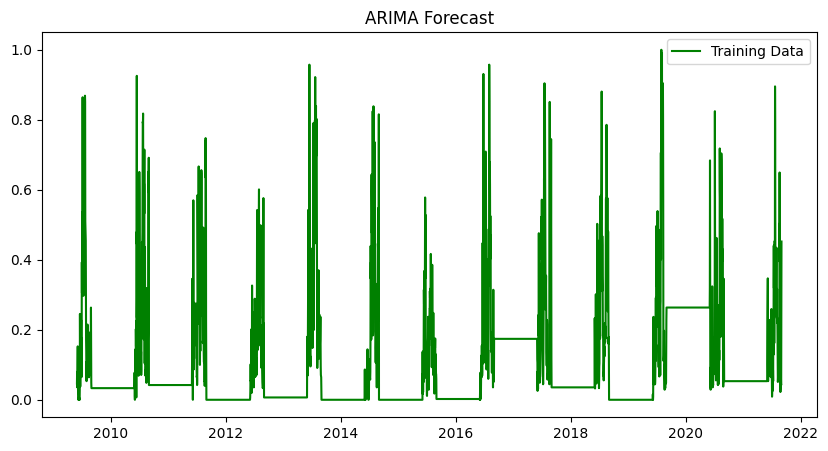

In [198]:
# Split the dataset into training and testing sets based on the date, with June 1, 2019, as the cutoff.
train_m = wf_monsoon[wf_monsoon.index <= pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
test_m = wf_monsoon[wf_monsoon.index > pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
plt.figure(figsize=(10, 5))
plt.plot(wf_monsoon['precipMM'], label="Training Data", color="green")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

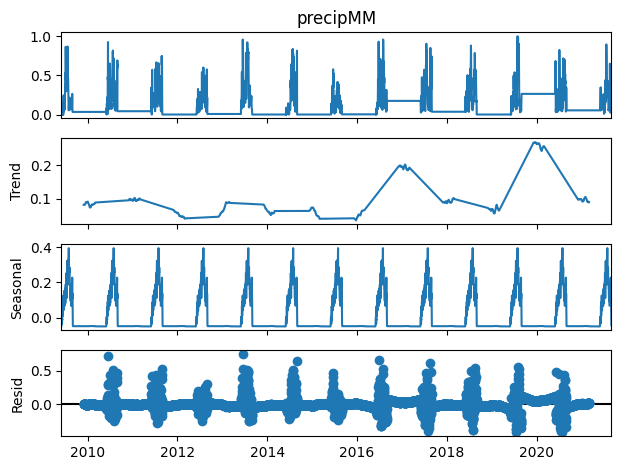

ADF Statistic: -5.667844086985084
p-value: 9.064904339519046e-07
The series is stationary.


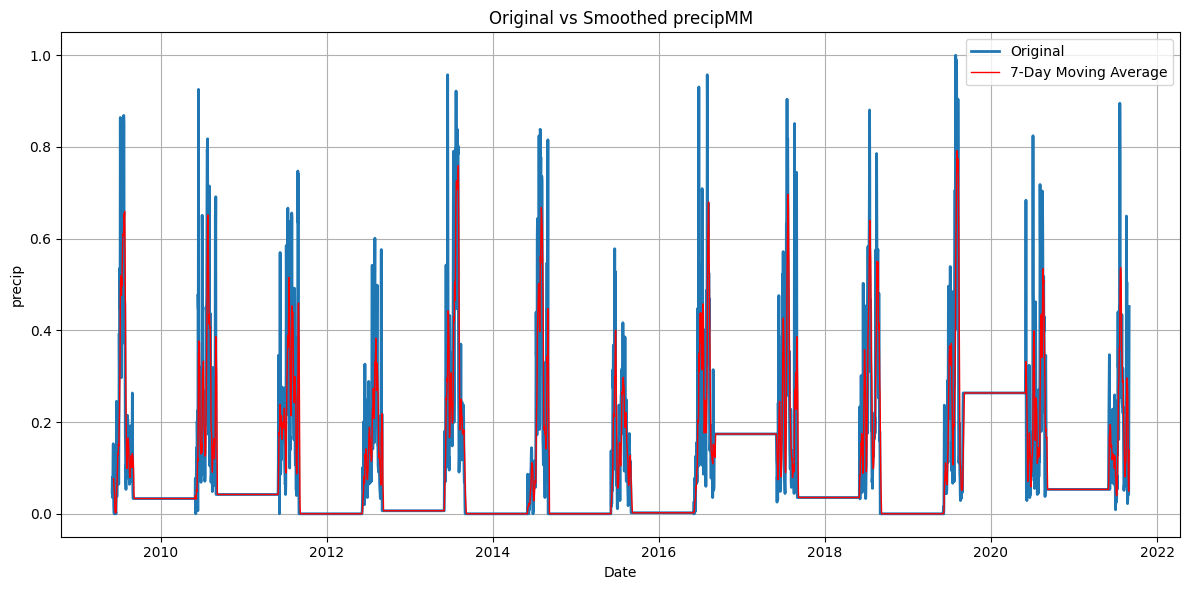

<Figure size 1200x600 with 0 Axes>

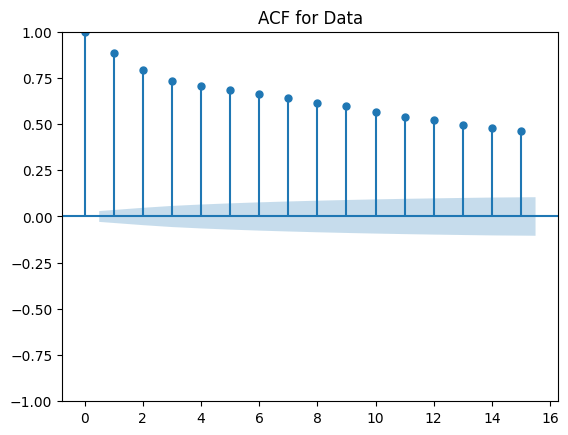

<Figure size 1200x600 with 0 Axes>

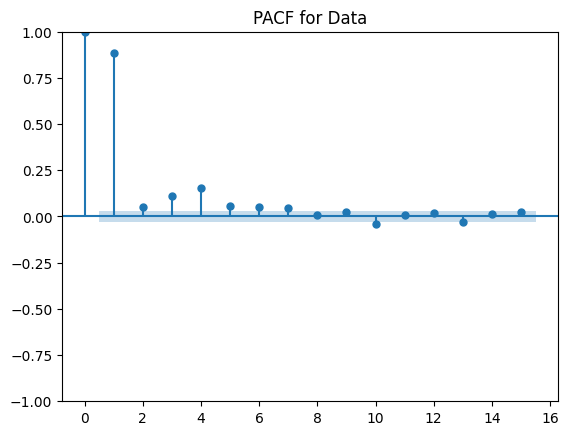

In [199]:
# Perform seasonal decomposition of rainfall data (precipMM) to analyze its trend, seasonality, and residuals.
# Plot the decomposition results to visualize these components.
precipMM_result = seasonal_decompose(wf_monsoon['precipMM'], model='additive', period=365)
precipMM_result.plot()
plt.show()

# Check stationarity of the rainfall data using the defined stationarity function.
check_stationarity(wf_monsoon['precipMM'])
precipMM_rolling = wf_monsoon['precipMM'].rolling(window=7).mean()
plt.figure(figsize=(12, 6))
plt.plot(wf_monsoon.index, wf_monsoon['precipMM'], label='Original', linewidth=2)
# Compute a 7-day moving average for rainfall data to smooth short-term fluctuations and compare it with the original.
plt.plot(wf_monsoon.index, precipMM_rolling, label='7-Day Moving Average', color='red', linewidth=1)
plt.title('Original vs Smoothed precipMM')
plt.xlabel('Date')
plt.ylabel('precip')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# Plot the Auto-Correlation Function (ACF) to identify significant lags for correlation in the rainfall data.
plt.figure(figsize=(12, 6))
plot_acf(wf_monsoon['precipMM'], lags=15)
plt.title('ACF for Data')
plt.show()
# Plot the Partial Auto-Correlation Function (PACF) to identify significant lags directly influencing the rainfall data.
plt.figure(figsize=(12, 6))
plot_pacf(wf_monsoon['precipMM'], lags=15)
plt.title('PACF for Data')
plt.show()

In [200]:
# Use auto_arima to automatically find the best ARIMA model for rainfall data based on AIC.
auto_model = auto_arima(train_m['precipMM'],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=None,
                        seasonal=False,
                        stepwise=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        max_order=None,
                        information_criterion='aic'
                        )

# Print the summary of the selected ARIMA model, including parameters and performance metrics.
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2573.387, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8920.426, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5566.034, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-8931.232, Time=0.55 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-8981.801, Time=0.63 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-9100.963, Time=0.95 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-9112.426, Time=1.29 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-9127.003, Time=7.89 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-9125.119, Time=3.27 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-9121.156, Time=4.64 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-9126.888, Time=4.76 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-9130.885, Time=9.33 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-9144.364, Time=10.89 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-9125.287, Time=12.00 sec
 ARIMA(4,0,0)(0,0

In [201]:
# Build an ARIMA model with specified parameters and exogenous variables for rainfall data.
m_model = ARIMA(train_m['precipMM'], order=(4, 0, 1),exog=train_m[['humidity', 'pressure','precipMM_lag_1','humidity_lag_1']])
# Fit the model to the training data and display the model summary.
m_model_fit = m_model.fit()
print(m_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               precipMM   No. Observations:                 3653
Model:                 ARIMA(4, 0, 1)   Log Likelihood                5103.990
Date:                Mon, 06 Jan 2025   AIC                         -10185.980
Time:                        18:52:58   BIC                         -10117.744
Sample:                    06-01-2009   HQIC                        -10161.680
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0197      0.004      4.794      0.000       0.012       0.028
humidity           0.6965      0.008     90.522      0.000       0.681       0.712
pressure          -0.0424      0.006

In [202]:
# Forecast rainfall for the test period using the fitted ARIMA model and exogenous variables.
m_forecast_steps = len(test_m)
m_forecast = m_model_fit.forecast(steps=m_forecast_steps,exog=test_m[['humidity', 'pressure','precipMM_lag_1','humidity_lag_1']])
# Create a date range for the forecasted values to align with the test dataset.
m_forecast_index = pd.date_range(start=test_m.index[0] + pd.Timedelta(days=1), periods=m_forecast_steps, freq='D')


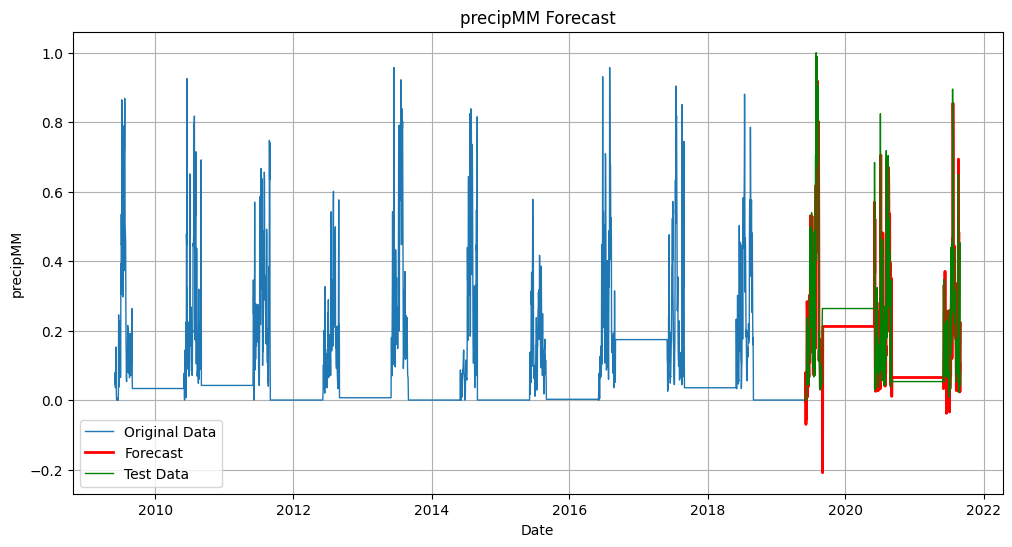

In [203]:
# Plot the original training data, forecasted rainfall, and actual test data for comparison.
# Visualize how well the forecast aligns with the test data over time.
plt.figure(figsize=(12, 6))
plt.plot(train_m.index, train_m['precipMM'], label='Original Data', linewidth=1)
plt.plot(m_forecast_index, m_forecast, label='Forecast', color='red', linewidth=2)
plt.plot(test_m.index, test_m['precipMM'], label='Test Data', color='green', linewidth=1)
plt.title('precipMM Forecast')
plt.xlabel('Date')
plt.ylabel('precipMM')
plt.legend()
plt.grid()
plt.show()


In [204]:
# Calculate and print evaluation metrics for the rainfall forecast:
# - MAE: Average absolute error between predicted and actual values.
mae = mean_absolute_error(test_m['precipMM'], m_forecast)
print("MAE:", mae)
# - RMSE: Root mean squared error to measure prediction accuracy.
rmse = np.sqrt(mean_squared_error(test_m['precipMM'], m_forecast))
print("RMSE:", rmse)
# - R²: Coefficient of determination indicating how well the model explains variance.
r2 = r2_score(test_m['precipMM'], m_forecast)
print("R²:", r2)

MAE: 0.05201742303303912
RMSE: 0.0818816014136983
R²: 0.7121941630809965


prophet

In [251]:
# Create a copy of the rainfall dataset and drop lagged feature columns.
# Display the first few rows of the updated dataset.
wf_mansoon_m = pd.DataFrame(wf_mansoon)
wf_mansoon_m.drop(columns=['precipMM_lag_1', 'humidity_lag_1'],inplace = True)
wf_mansoon_m.head()

,precipMM,humidity,pressure
date_time,,,
2009-06-01,0.046543,0.324733,0.691039
2009-06-02,0.079787,0.337189,0.759697
2009-06-03,0.035461,0.346085,0.831476
2009-06-04,0.070922,0.436833,0.709764
2009-06-05,0.090869,0.509786,0.534998


In [252]:
# Add a 'ds' column for datetime and a 'y' column for rainfall (precipMM) as required for Prophet.
wf_mansoon_m['ds'] = pd.to_datetime(wf_mansoon_m.index)
wf_mansoon_m['y'] = wf_mansoon_m['precipMM']
wf_mansoon_m.head()

# Split the dataset into training and testing sets based on the date, with June 1, 2019, as the cutoff.
train_m_p = wf_mansoon_m[wf_mansoon_m.index <= pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
test_m_p = wf_mansoon_m[wf_mansoon_m.index > pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object

In [207]:
# Initialize a Prophet model with a 68% confidence interval and fit it to the training data.
m_p_model = Prophet(interval_width = 0.68)
m_p_model.fit(train_m_p)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnt6t8/4teo9oa5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnt6t8/7nblcd59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37205', 'data', 'file=/tmp/tmprjwnt6t8/4teo9oa5.json', 'init=/tmp/tmprjwnt6t8/7nblcd59.json', 'output', 'file=/tmp/tmprjwnt6t8/prophet_modely0iskida/prophet_model-20250106185259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [208]:
# Create a future dataframe for the Prophet model to forecast rainfall for the test period, matching its length.
m_p_forecast_steps=len(test_m_p)
m_p_future = m_p_model.make_future_dataframe(periods=m_p_forecast_steps,freq='D')

In [209]:
# Generate rainfall predictions using the Prophet model for the future dataframe.
m_p_forecast = m_p_model.predict(m_p_future)
# Display the last few rows of the forecast, including predicted values (yhat) and confidence intervals
m_p_forecast[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
4470,2021-08-27,-0.016322,-0.139088,0.099164,-0.090896,-0.137814,-0.038717
4471,2021-08-28,-0.018277,-0.127641,0.097778,-0.091052,-0.138067,-0.038728
4472,2021-08-29,-0.022350,-0.132261,0.094197,-0.091208,-0.138327,-0.038861
4473,2021-08-30,-0.029381,-0.145026,0.079088,-0.091365,-0.138587,-0.039039
4474,2021-08-31,-0.035734,-0.146112,0.073430,-0.091521,-0.138847,-0.039190


In [210]:
# Extract the actual values (y_true) from the dataset and predicted values (y_pred) from the Prophet forecast.
# Ensure the predictions are aligned with the length of the actual data.
y_true = wf_mansoon_m['y'].values  # Replace 'y' with your target column name
y_pred = m_p_forecast['yhat'][:len(y_true)].values

In [211]:
# Combine the training and testing datasets into a single DataFrame for further analysis or visualization.
wf_prophet_m = pd.concat([train_m_p,test_m_p])

In [212]:

# Merge actual and forecasted data
m_p_forecast_actual = pd.merge(test_m_p, m_p_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

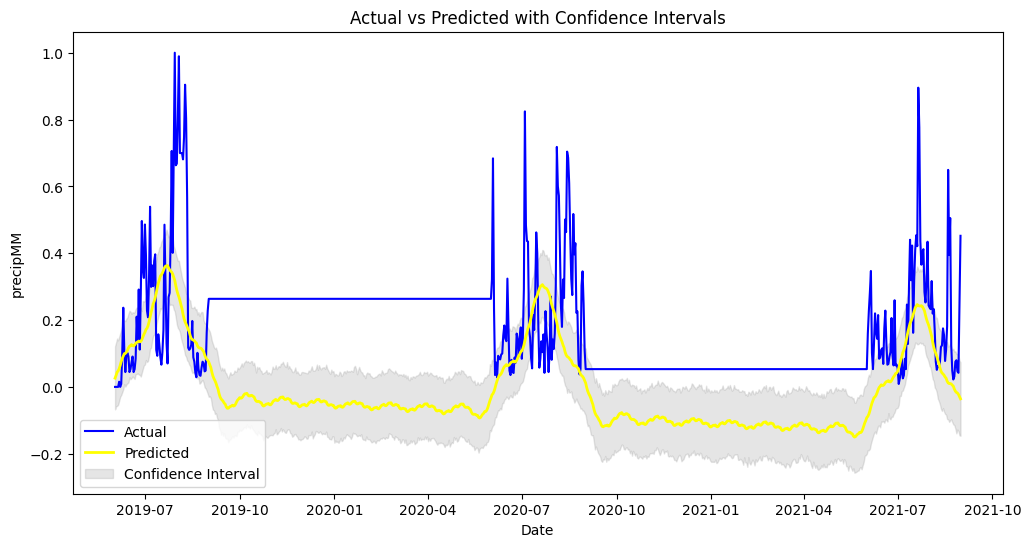

,yhat
0,0.073928
1,0.083423
2,0.087278
3,0.094186
4,0.104407
...,...
4470,-0.016322
4471,-0.018277
4472,-0.022350
4473,-0.029381


In [235]:


# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(m_p_forecast_actual['ds'], m_p_forecast_actual['y'], label='Actual', color='blue')
plt.plot(m_p_forecast_actual['ds'], m_p_forecast_actual['yhat'], label='Predicted', color='yellow',linewidth=2)
plt.fill_between(m_p_forecast_actual['ds'],
                 m_p_forecast_actual['yhat_lower'],
                 m_p_forecast_actual['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title("Actual vs Predicted with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("precipMM")
plt.legend()
plt.show()

m_p_forecast['yhat']

In [239]:
# Ensure y_pred has the same length as wf_prophet_m["y"]
y_pred_subset = m_p_forecast['yhat'][:len(wf_prophet_m["y"])]

In [245]:
# Calculate and print evaluation metrics to assess the Prophet model's performance:
# - MSE: Measures the average squared difference between actual and predicted values.
print("Mean Squared Error (MSE):", mean_squared_error(y_true = y_test, y_pred = y_pred))
# - MAE: Calculates the average absolute error between actual and predicted values.
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = y_test, y_pred = y_pred))
# - RMSE: Represents the square root of the mean squared error for prediction accuracy.
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred)))
# - R²: Indicates how well the model explains the variance in the data.
print("R-squared (R²):", r2_score(y_true = y_test, y_pred = y_pred))

Mean Squared Error (MSE): 0.010002499515229763
Mean Absolute Error (MAE): 0.08092421837703215
Root Mean Squared Error (RMSE): 0.10001249679529935
R-squared (R²): 0.41013770160340735


tunning

In [246]:
# Simplified hyperparameter grid
param_grid = {
    "changepoint_prior_scale": [0.01, 0.1, 0.5, 1.0],
    "seasonality_prior_scale": [0.1, 1.0, 10.0],
}

# Update the function and grid search accordingly
# Remove holidays_prior_scale from function arguments
def evaluate_prophet(data, changepoint_prior_scale, seasonality_prior_scale):
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    model.fit(data)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    forecast_trimmed = forecast[:len(data)]
    error = mean_absolute_error(data['y'], forecast_trimmed['yhat'])
    return error

# Update all_params and perform grid search
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

results = []
for params in all_params:
    error = evaluate_prophet(
        train_m_p,
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"]
    )
    results.append((params, error))

best_params, best_error = min(results, key=lambda x: x[1])

print("Best Parameters:", best_params)
print("Best Error (MAE):", best_error)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnt6t8/wu6eglpm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnt6t8/_45fq6lo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1444', 'data', 'file=/tmp/tmprjwnt6t8/wu6eglpm.json', 'init=/tmp/tmprjwnt6t8/_45fq6lo.json', 'output', 'file=/tmp/tmprjwnt6t8/prophet_modell1cz_b3h/prophet_model-20250106192547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjw

Best Parameters: {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}
Best Error (MAE): 0.046519060443078956


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnt6t8/trz399w5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnt6t8/pa49zo42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19045', 'data', 'file=/tmp/tmprjwnt6t8/trz399w5.json', 'init=/tmp/tmprjwnt6t8/pa49zo42.json', 'output', 'file=/tmp/tmprjwnt6t8/prophet_modelynadwdv3/prophet_model-20250106192804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:28:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


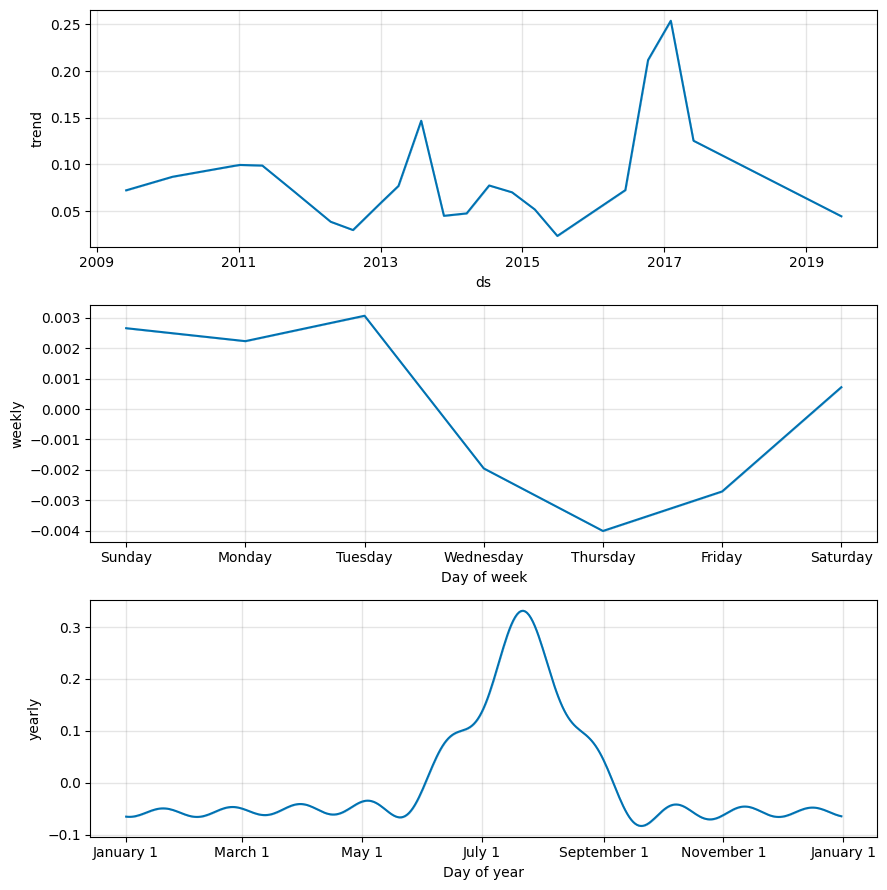

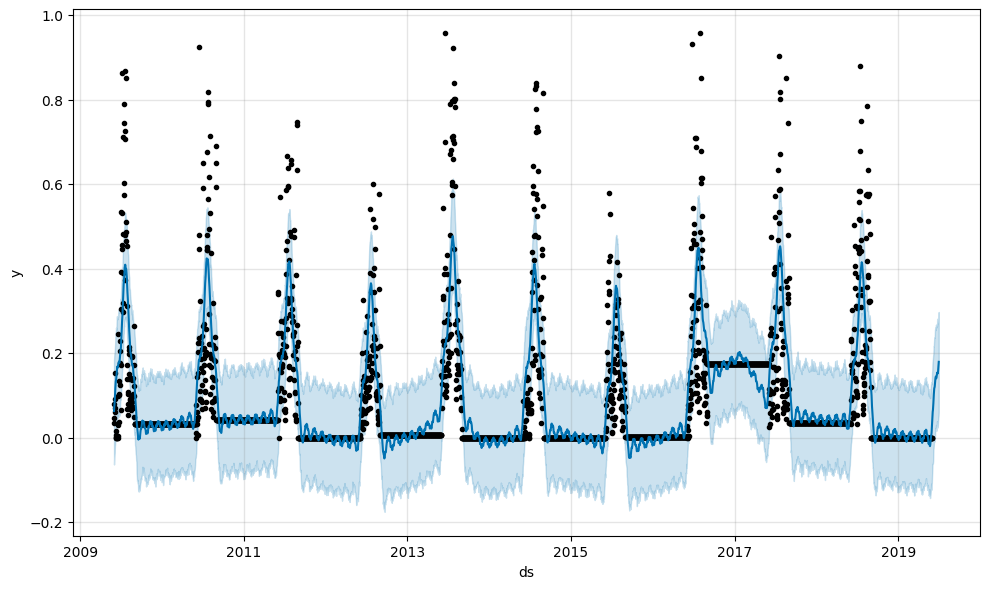

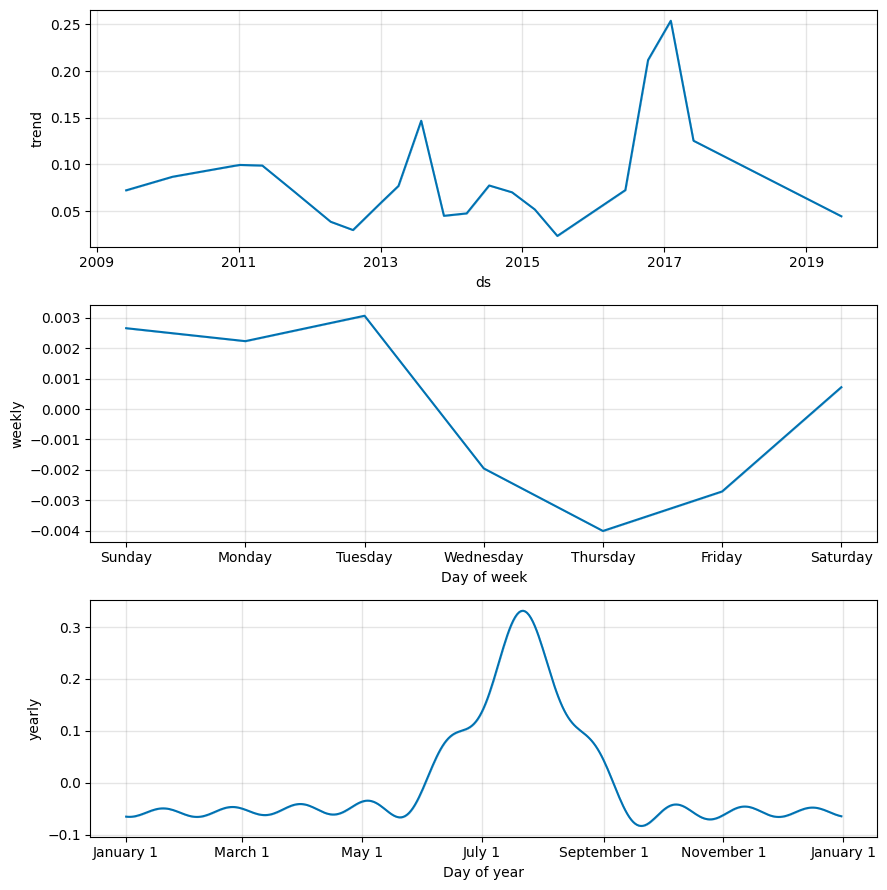

In [247]:
# Train the model with the best parameters
best_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
)
best_model.fit(train_m_p)

# Forecast future values
future = best_model.make_future_dataframe(periods=30)
forecast = best_model.predict(future)

# Plot the forecast
best_model.plot(forecast)
best_model.plot_components(forecast)


In [253]:


# Merge forecasted values with the original data for comparison
forecast_evaluation = forecast.merge(wf_mansoon_m, on="ds", how="left", suffixes=("_forecast", "_actual"))

# Calculate metrics
y_actual = forecast_evaluation["y"].dropna()  # Drop any NaN values
y_pred = forecast_evaluation["yhat"][:len(y_actual)]  # Match the length of actual values

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_actual, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# coeeficient of determination
print("R-squared (R²):", r2_score(y_actual, y_pred))


Mean Absolute Error (MAE): 0.04686612653299208
Root Mean Squared Error (RMSE): 0.008855070461524247
R-squared (R²): 0.5951200058633275


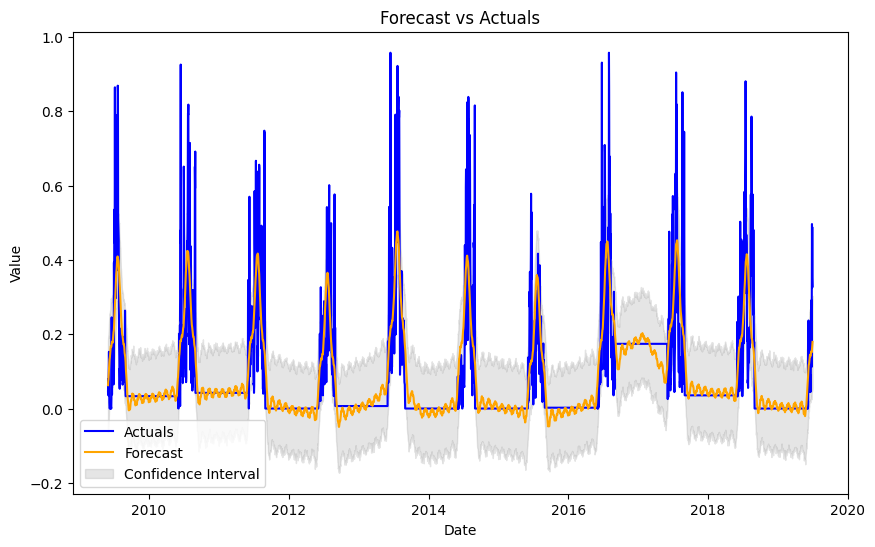

In [219]:

#Plot the forecasted values against the actual values:
plt.figure(figsize=(10, 6))
# - Blue Line: Represents the actual observed data (y).
plt.plot(forecast_evaluation["ds"], forecast_evaluation["y"], label="Actuals", color="blue")
# - Orange Line: Represents the predicted values (yhat) from the Prophet model.
plt.plot(forecast_evaluation["ds"], forecast_evaluation["yhat"], label="Forecast", color="orange")
# - Gray Shaded Area: Shows the confidence interval around the forecast (yhat_lower and yhat_upper).
plt.fill_between(
    forecast_evaluation["ds"],
    forecast_evaluation["yhat_lower"],
    forecast_evaluation["yhat_upper"],
    color="gray",
    alpha=0.2,
    label="Confidence Interval"
)
# Add legends, title, and labels for clear visualization.
plt.legend()
plt.title("Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()


Cnn-Lstm Model for Mansoon data

In [220]:
def sequence_creating(data,seq_len,target_col):
  X, y = [], []
  for i in range(len(data) - seq_len):
    X.append(data.iloc[i:i+seq_len, 1:].values)
    y.append(data.iloc[i+seq_len][target_col])
  return np.array(X), np.array(y)

# Set the sequence length and target column for rainfall forecasting.
sequence_length = 90
target_column = 'precipMM'
# Generate sequences for the training and testing datasets.
X_train, y_train = sequence_creating(train_m,sequence_length,target_column)
X_test, y_test = sequence_creating(test_m,sequence_length,target_column)

# Print the shapes of the input features and target arrays for both training and testing.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3563, 90, 4)
(3563,)
(732, 90, 4)
(732,)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 86, 128)             │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100)                 │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,389 (368.71 KB)

 Trainable params: 94,389 (368.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - loss: 0.0101 - mae: 0.0547 - val_loss: 0.0279 - val_mae: 0.1279
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 0.0090 - mae: 0.0469 - val_loss: 0.0285 - val_mae: 0.1201
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0087 - mae: 0.0461 - val_loss: 0.0219 - val_mae: 0.1249
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 0.0077 - mae: 0.0397 - val_loss: 0.0195 - val_mae: 0.1245
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.0071 - mae: 0.0388 - val_loss: 0.0207 - val_mae: 0.1298
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - loss: 0.0078 - mae: 0.0428 - val_loss: 0.0191 - val_mae: 0.1043
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0074 - mae: 0.0391 - val_loss: 0.0138 - val_mae: 0.1021
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0059 - mae: 0.0350 - val_loss: 0.0138 - val_mae: 0.0989
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 

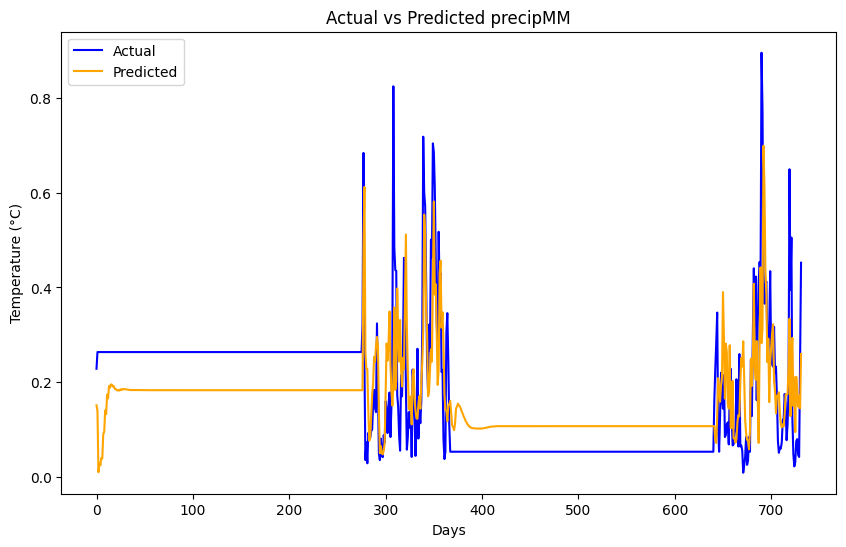

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [238]:

# Define and build a CNN-LSTM model for time series forecasting:
model_man = Sequential()
# - Conv1D Layer: Extracts local patterns from the sequences.
model_man.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
# - MaxPooling1D Layer: Reduces dimensionality and retains essential features.
model_man.add(MaxPooling1D(pool_size=2))
# - LSTM Layer: Captures temporal dependencies in the data.
model_man.add(LSTM(100, activation='relu', return_sequences=False))

#model.add(Flatten())
# - Dense Layer: Produces the final output prediction.
model_man.add(Dense(1))
# Compile the model using the Adam optimizer, Mean Squared Error (MSE) loss, and Mean Absolute Error (MAE) as a metric.

model_man.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display the model summary to review its architecture.
model_man.summary()

# Train the model using the training data:
# - Train for 50 epochs with a batch size of 32.
# - Validate the model on the test data during training.
history = model_man.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
# Predict the target variable (rainfall) using the test data.
y_pred = model_man.predict(X_test)


# Visualize the Actual vs Predicted values:
# - Blue Line: Actual rainfall values from the test set.
# - Orange Line: Predicted rainfall values from the model.
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='orange')
plt.title('Actual vs Predicted precipMM')
plt.xlabel('Days')
plt.ylabel('precipMM')
plt.legend()
plt.show()

test.shape

# Make additional predictions using the test data if needed.
y_pred = model_man.predict(X_test)


In [241]:
# Evaluate the CNN-LSTM model's performance on the test data:
# - RMSE: Calculate the Root Mean Squared Error to measure the average magnitude of prediction errors.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# - MAE: Calculate the Mean Absolute Error to assess the average absolute difference between predictions and actual values.
mae = mean_absolute_error(y_test, y_pred)
# - R²: Compute the Coefficient of Determination to evaluate how well the model explains variance in the data.
r2 = r2_score(y_test, y_pred)

# Print the calculated metrics to assess the model's accuracy.
print("Test RMSE: ", rmse)
print("Test MAE: ", mae)
print("R²:", r2)

Test RMSE:  0.10001249679529935
Test MAE:  0.08092421837703215
R²: 0.41013770160340735


Teporal FusionTransformer Model

In [223]:
# Load the dataset from a CSV file into a Pandas DataFrame and display the first few rows.\
tft_data = pd.read_csv('out.csv')
tft_data.head()
# Print the type of the loaded object to confirm it is a DataFrame.
print(type(tft_data))

<class 'pandas.core.frame.DataFrame'>


In [224]:
# Convert the index of the dataset to a datetime format for time series operations.
# Display the first few rows of the updated dataset to confirm the change.
tft_data.index = pd.to_datetime(tft_data.index)
tft_data.head()

,tempC,humidity,pressure
1970-01-01 00:00:00.000000000,22,37,1012
1970-01-01 00:00:00.000000001,22,44,1013
1970-01-01 00:00:00.000000002,22,47,1014
1970-01-01 00:00:00.000000003,22,52,1013
1970-01-01 00:00:00.000000004,22,51,1011


In [225]:
# Scaling 'tempC', 'humidity', and 'pressure' columns to a 0-1 range using MinMaxScaler.
scaler = MinMaxScaler()
tft_data[['tempC', 'humidity', 'pressure']] = scaler.fit_transform(tft_data[['tempC', 'humidity', 'pressure']])


# Backfilling missing values caused by lagging.
tft_data.fillna(method = 'bfill',inplace=True)
tft_data.head()




In [226]:


# Add time index
tft_data["time_idx"] = np.arange(len(tft_data))
print(type(tft_data))
# Scale numerical features
scaler = MinMaxScaler()
tft_data[["tempC", "humidity", "pressure"]] = scaler.fit_transform(tft_data[["tempC", "humidity", "pressure"]])

# Static covariate
tft_data["group"] = 0  # Only one time series

print(type(tft_data))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [227]:
# Split into training and validation
train_size = int(0.8 * len(tft_data))
train_data = tft_data.iloc[:train_size]
val_data = tft_data.iloc[train_size:]
print(type(train_size))
print(type(train_data))
print(type(val_data))

<class 'int'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [228]:

# Define max lengths for encoder and decoder
max_encoder_length = 30  # Historical context
max_prediction_length = 7  # Forecast horizon

# Create TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",  # Time index column
    target="tempC",  # Target column
    group_ids=["group"],  # Group identifier
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],  # Known covariates (e.g., time_idx)
    time_varying_unknown_reals=["tempC", "humidity", "pressure"],  # Unknown covariates
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Create validation dataset from training
validation = TimeSeriesDataSet.from_dataset(training, val_data, predict=True, stop_randomization=True)

print(type(training))
print(type(validation))

<class 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet'>
<class 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet'>


In [ ]:
# Create DataLoaders for the training and validation datasets:
# - `train_dataloader`: Loads the training data in batches of size 64.
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
# - `val_dataloader`: Loads the validation data in batches of size 64.
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)

# Print the types of the DataLoaders to confirm their creation.
print(type(train_dataloader))
print(type(val_dataloader))

In [229]:

# Initialize a Temporal Fusion Transformer (TFT) model from the training dataset:
tft_model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,# - `learning_rate`: Set the initial learning rate for training.
    hidden_size=16,  # Hidden layer size
    attention_head_size=4,  # Number of attention heads
    dropout=0.1,
    hidden_continuous_size=8,  # Size of continuous variable embeddings
    output_size=1,  # Output dimension (1 for regression)
    loss=QuantileLoss(),  # Loss function
    reduce_on_plateau_patience=4,  # Reduce LR on plateau
)

# Print the type of the initialized TFT model to confirm its creation.
print(type(tft_model))

<class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>


In [230]:
# Check if the dataset (tft_data) is empty:



if len(tft_data) == 0:
    print("The list is empty")# - If the length of the dataset is 0, print "The list is empty."
else:
    print("The list is not empty")# - Otherwise, print "The list is not empty."

The list is not empty


In [231]:


class WrappedTFT(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model  # Temporal Fusion Transformer (TFT) model
        self.validation_outputs = []  # To store validation outputs

    def forward(self, x):
        # Forward pass through the TFT model
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch  # Unpack the tuple into features (x) and target (y)

        # If x is a dictionary (common in PyTorch Forecasting), move tensors inside it to the device
        if isinstance(x, dict):
            x = {key: value.to(self.device) for key, value in x.items() if isinstance(value, torch.Tensor)}
        else:
            x = x.to(self.device)

        # Move target tensor to the device
        y = y[0].to(self.device)  # Extract target and move to device

        # Forward pass through the TFT model
        output = self.tft_model(x)

        # Debugging: Inspect shapes of predictions and target
        predictions = output["prediction"]  # Adjust based on model output

        # Ensure shapes match for loss calculation
        if predictions.shape[-1] == 1:
            predictions = predictions.squeeze(-1)  # Remove feature dimension if present
        y = y.view_as(predictions)  # Reshape target to match predictions

        # Calculate the loss
        loss = F.mse_loss(predictions, y)  # Replace with the appropriate loss function
        self.log("train_loss", loss, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch  # Unpack the tuple into features (x) and target (y)

        # If x is a dictionary (common in PyTorch Forecasting), move tensors inside it to the device
        if isinstance(x, dict):
            x = {key: value.to(self.device) for key, value in x.items() if isinstance(value, torch.Tensor)}
        else:
            x = x.to(self.device)

        # Move target tensor to the device
        y = y[0].to(self.device)  # Extract target and move to device

        # Forward pass through the TFT model
        output = self.tft_model(x)

        # Debugging: Inspect shapes of predictions and target
        predictions = output["prediction"]  # Adjust based on model output

        # Ensure shapes match for loss calculation
        if predictions.shape[-1] == 1:
            predictions = predictions.squeeze(-1)  # Remove feature dimension if present
        y = y.view_as(predictions)  # Reshape target to match predictions

        # Calculate the loss
        loss = F.mse_loss(predictions, y)

        # Save validation outputs for later processing
        self.validation_outputs.append({"val_loss": loss})

        # Log the metrics
        self.log("val_loss", loss, prog_bar=True, logger=True)

        return {"val_loss": loss}
    def on_validation_epoch_end(self):
        # Process validation outputs at the end of the epoch
        avg_loss = torch.stack([output["val_loss"] for output in self.validation_outputs]).mean()

        # Log the average metrics
        self.log("avg_val_loss", avg_loss, prog_bar=True, logger=True)

        # Clear the outputs for the next epoch
        self.validation_outputs = []

    def configure_optimizers(self):
        # Define optimizer and learning rate scheduler
        optimizer = torch.optim.Adam(self.tft_model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]


In [232]:
# Retrieve the type of the `tft_model` object and assign it to the variable `tft1`.
tft1 = type(tft_model)
# Print the type to confirm the class or structure of the Temporal Fusion Transformer model.
print(tft1)

<class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>


In [233]:
# Wrap the TFT model
lightning_tft = WrappedTFT(tft_model)

# Define the Trainer
trainer = Trainer(
    max_epochs=10,
    gradient_clip_val=0.1,
    devices=1,  # Use GPU
    accelerator="cpu"  # Ensure GPU usage
)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [234]:
# Train the model
trainer.fit( lightning_tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 19.6 K | train
----------------------------------------------------------------
19.6 K    Trainable params
0         Non-trainable params
19.6 K    Total params
0.078     Total estimated model params size (MB)
310       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Validate the Temporal Fusion Transformer (TFT) model using the validation DataLoader.
# - `lightning_tft`: The initialized and trained TFT model wrapped in a PyTorch Lightning module.
# - `val_dataloader`: The DataLoader for the validation dataset.
# The validation process evaluates the model's performance on unseen data and outputs metrics.
trainer.validate(lightning_tft, dataloaders=val_dataloader)